# Predict the probability of a candidate leaving for a new job

### Task 

This dataset is designed to understand the factors that lead to a person to work for a different company(leaving current job), by model(s) that uses the current credentials/demographics/experience to predict the probability of a candidate to look for a new job or will work for the company.

### Features

enrollee_id : Unique ID for candidate

city: City code

city_ development _index : Developement index of the city (scaled)

gender: Gender of candidate

relevent_experience: Relevant experience of candidate

enrolled_university: Type of University course enrolled if any

education_level: Education level of candidate

major_discipline :Education major discipline of candidate

experience: Candidate total experience in years

company_size: No of employees in current employer's company

company_type : Type of current employer

lastnewjob: Difference in years between previous job and current job

training_hours: training hours completed

target: 0 – Not looking for job change, 1 – Looking for a job change

### Inspiration
Predict the probability of a candidate will work for the company
Interpret model(s) such a way that illustrate which features affect candidate decision

##### Note:
The dataset is imbalanced.
Most features are categorical (Nominal, Ordinal, Binary), some with high cardinality.
Missing imputation can be a part of your pipeline as well.

In [119]:
#imports 

import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import missingno
import multiprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score as auc


## Import data 

In [2]:
train = pd.read_csv('./aug_train.csv')
test = pd.read_csv('./aug_test.csv')
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [3]:
print('train:',train.shape)
print('test:',test.shape)

train: (19158, 14)
test: (2129, 13)


In [4]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [5]:
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [6]:
categorical_vars = set(train.columns[train.dtypes == object])
numerical_vars = set(train.columns) - categorical_vars
categorical_vars = list(categorical_vars)
numerical_vars = list(numerical_vars)
print(categorical_vars)
print(numerical_vars)

['major_discipline', 'education_level', 'enrolled_university', 'company_type', 'gender', 'company_size', 'last_new_job', 'city', 'experience', 'relevent_experience']
['target', 'enrollee_id', 'city_development_index', 'training_hours']


In [7]:
test_categorical_vars = set(test.columns[test.dtypes == object])
test_numerical_vars =  set(test.columns) - test_categorical_vars
test_categorical_vars= list(test_categorical_vars)
test_numerical_vars = list(test_numerical_vars)
print(test_categorical_vars)
print(test_numerical_vars)

['major_discipline', 'education_level', 'enrolled_university', 'company_type', 'gender', 'company_size', 'last_new_job', 'city', 'experience', 'relevent_experience']
['training_hours', 'enrollee_id', 'city_development_index']


##  EDA and visualization

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [9]:
train.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [10]:
train.describe(exclude = 'number')

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,19158,14650,19158,18772,18698,16345,19093,13220,13018,18735
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,4355,13221,13792,13817,11598,14492,3286,3083,9817,8040


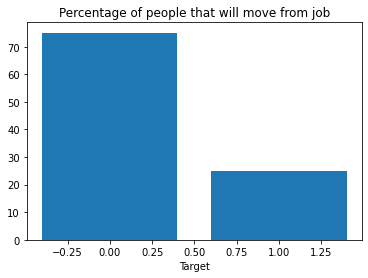

target
0.0    75.065247
1.0    24.934753
Name: counts, dtype: float64


In [11]:
# checking the target

targ_dist = pd.crosstab( train['target'], columns = 'counts', normalize = 'columns')*100
plt.bar(targ_dist.index, targ_dist['counts'])
plt.xlabel('Target')
plt.title('Percentage of people that will move from job')
plt.show()

print(targ_dist['counts'])

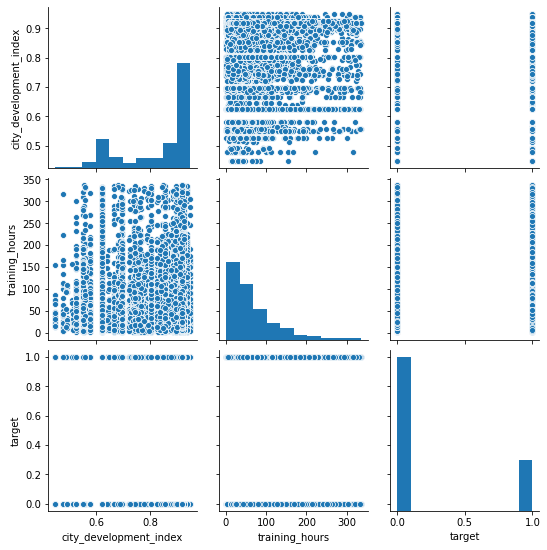

In [12]:
col = ['city_development_index','training_hours', 'target']
sns.pairplot(train[col], diag_kind = 'hist')

In [13]:
train.groupby('target').training_hours.describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,14381.0,66.113761,60.938937,1.0,23.0,48.0,90.0,336.0
1.0,4777.0,63.118484,57.273662,1.0,23.0,46.0,86.0,336.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EE76E0B6A0>,
      dtype=object)

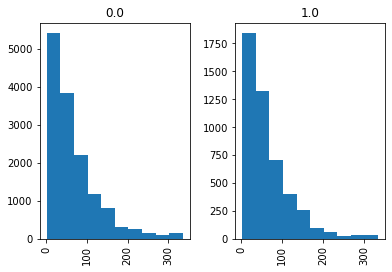

In [14]:
train['training_hours'].hist(by = train['target'])
#distribution is the same 

Text(0.5, 1.0, 'Distribution of city development index')

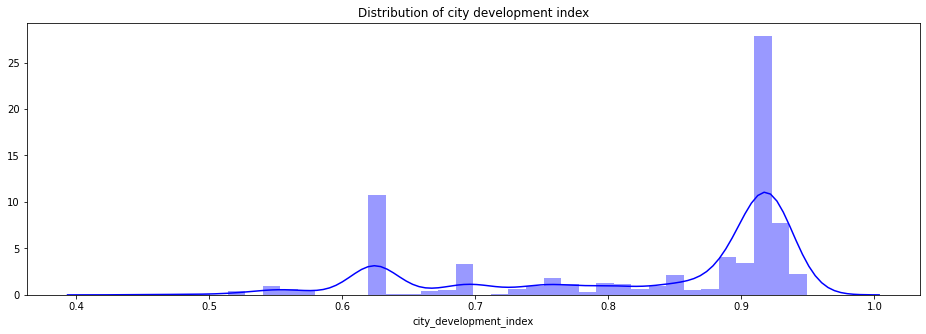

In [15]:
f, axes = plt.subplots(1,1, figsize = (16, 5))
g1 = sns.distplot(train["city_development_index"], color="blue",ax = axes)
plt.title("Distribution of city development index")

In [16]:
train.groupby('target').city_development_index.describe()


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,14381.0,0.853139,0.105354,0.448,0.804,0.91,0.92,0.949
1.0,4777.0,0.755719,0.143166,0.448,0.624,0.74,0.92,0.949


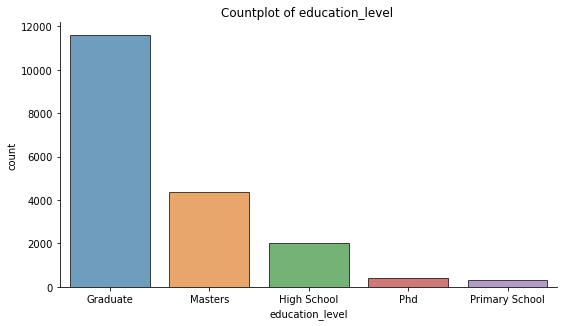

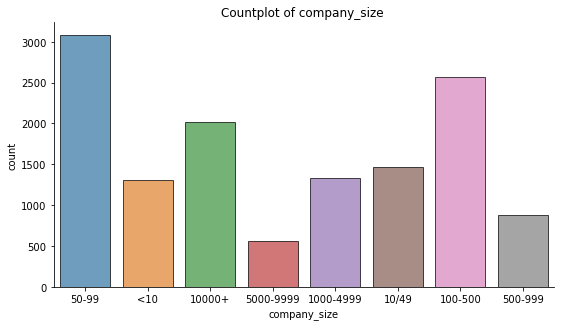

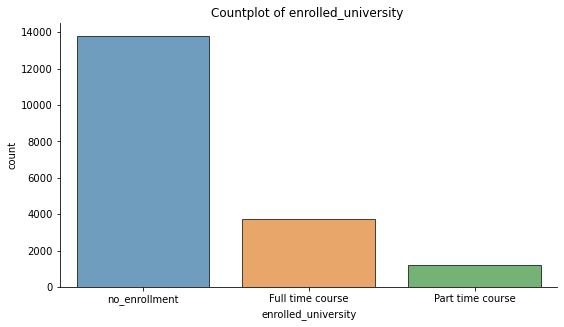

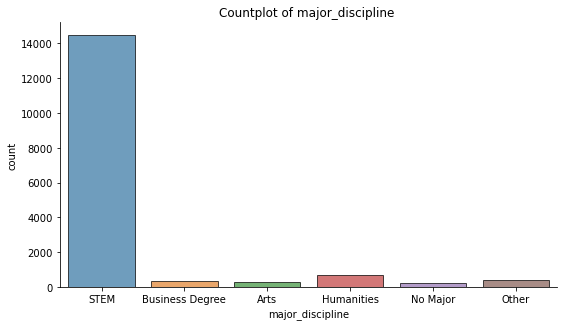

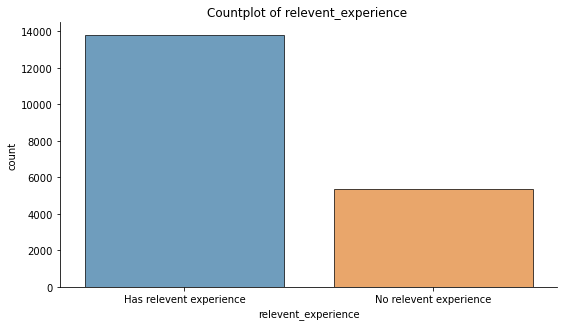

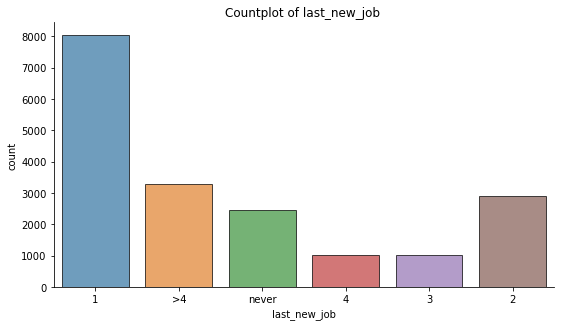

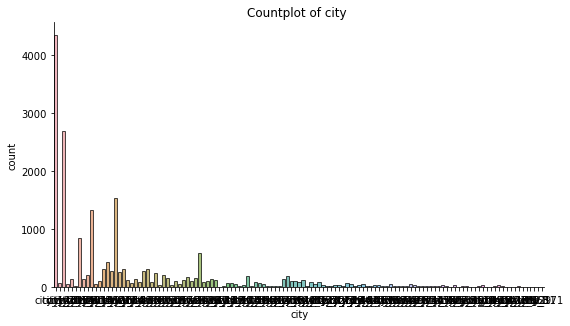

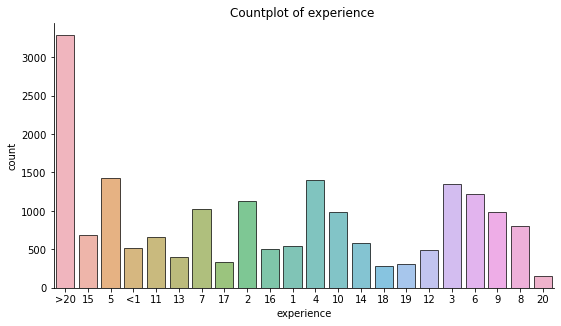

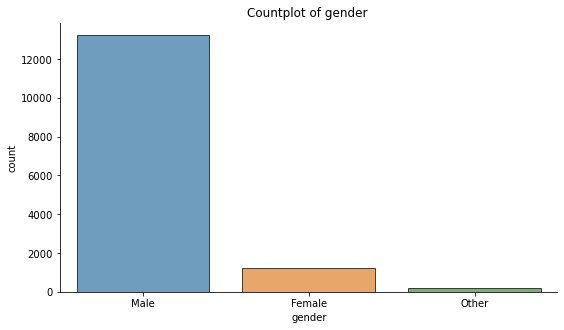

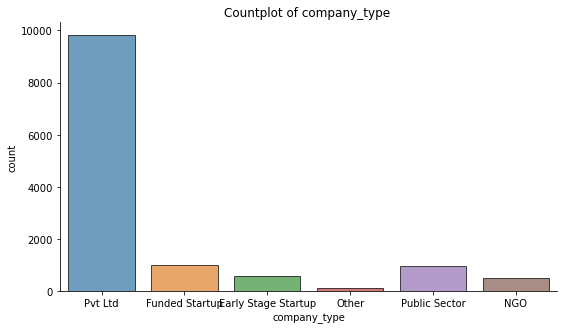

In [17]:
y = ['education_level', 'company_size', 'enrolled_university', 'major_discipline', 'relevent_experience', 'last_new_job', 'city', 'experience', 'gender', 'company_type']
n=1
for i in y:
    plt.figure(figsize=[15,17])
    plt.subplot(4,2,n)
    sns.countplot(x= i, edgecolor='black', alpha=0.7, data = train)
    sns.despine()
    plt.title("Countplot of {} ".format(i))
    n=n+1/4
    plt.tight_layout()
    plt.show()

## Data pre-processing 

First, lets deal with missing values.

Ways to get around this:

1. You can drop columns having very large amount of missing values

2. Drop the entire row ( not recommendable, we will lose lots of data)

3. Convert none null categorical data into numarical form and then simply fill mean, mode or median value inplace of null     values

4. Convert none null categorical data into numarical form and then with the help of lusteing algorithm find missing values   and impute them in data for each group

5. train a regression model that tries to predict missing values in a column based on other columns.


### Train Dataset

In [18]:
train.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

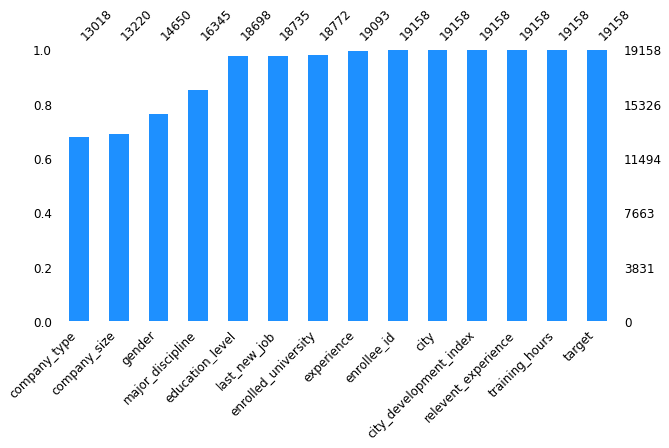

In [19]:
missingno.bar(train,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12)

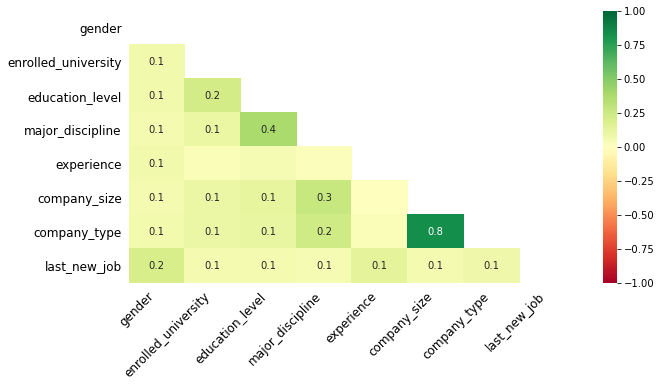

In [20]:
missingno.heatmap(train, cmap="RdYlGn", figsize=(10,5), fontsize=12)
#checking if there's relation between NaNs in the variables
# 1 => if value Xi is present Xj too
# 0 => no relation between the presences of NaNs
#-1 => if value Xi is not present Xj won't be either

Now that we have check there's no relation between NaNs that might have information we replace them by means of k-nearest neighbour method. We are using the KNN imputer implementation for filling missing values.

Steps: 

1. encode by hand variables with missing values.
2. encode by LabelEncoder the complete ones.
3. Slipt the data set in variables with NaNs and variables without
4. apply KNN to fill up the missing values
5. merge tables to get the final training data

In [21]:
gender_map = {
        'Female': 2,
        'Male': 1,
        'Other': 0
         }


enrolled_university_map = {
    'no_enrollment'   :  0,
    'Full time course':    1, 
    'Part time course':    2 
}
    
education_level_map = {
    'Primary School' :    0,
    'Graduate'       :    2,
    'Masters'        :    3, 
    'High School'    :    1, 
    'Phd'            :    4
    } 
    
major_map ={ 
    'STEM'                   :    0,
    'Business Degree'        :    1, 
    'Arts'                   :    2, 
    'Humanities'             :    3, 
    'No Major'               :    4, 
    'Other'                  :    5 
}
    
experience_map = {
    '<1'      :    0,
    '1'       :    1, 
    '2'       :    2, 
    '3'       :    3, 
    '4'       :    4, 
    '5'       :    5,
    '6'       :    6,
    '7'       :    7,
    '8'       :    8, 
    '9'       :    9, 
    '10'      :    10, 
    '11'      :    11,
    '12'      :    12,
    '13'      :    13, 
    '14'      :    14, 
    '15'      :    15, 
    '16'      :    16,
    '17'      :    17,
    '18'      :    18,
    '19'      :    19, 
    '20'      :    20, 
    '>20'     :    21
} 
    
company_type_map = {
    'Pvt Ltd'               :    0,
    'Funded Startup'        :    1, 
    'Early Stage Startup'   :    2, 
    'Other'                 :    3, 
    'Public Sector'         :    4, 
    'NGO'                   :    5
}

company_size_map = {
    '<10'          :    0,
    '10/49'        :    1, 
    '100-500'      :    2, 
    '1000-4999'    :    3, 
    '10000+'       :    4, 
    '50-99'        :    5, 
    '500-999'      :    6, 
    '5000-9999'    :    7
}
    
last_new_job_map = {
    'never'        :    0,
    '1'            :    1, 
    '2'            :    2, 
    '3'            :    3, 
    '4'            :    4, 
    '>4'           :    5
}

In [22]:
train1 = train

In [23]:

train1.loc[:,'education_level'] = train['education_level'].map(education_level_map)
train1.loc[:,'gender'] = train['gender'].map(gender_map)
train1.loc[:,'enrolled_university'] = train['enrolled_university'].map(enrolled_university_map)
train1.loc[:,'experience'] = train['experience'].map(experience_map)
train1.loc[:,'company_size'] = train['company_size'].map(company_size_map)
train1.loc[:,'company_type'] = train['company_type'].map(company_type_map)
train1.loc[:,'last_new_job'] = train['last_new_job'].map(last_new_job_map)
train1.loc[:,'major_discipline'] = train['major_discipline'].map(major_map)

lb_en = LabelEncoder()

train.loc[:,'city'] = lb_en.fit_transform(train.loc[:,'city']) 
train.loc[:,'relevent_experience'] = lb_en.fit_transform(train.loc[:,'relevent_experience'])


In [24]:
y = ['education_level', 'company_size', 'enrolled_university', 'major_discipline', 'relevent_experience', 'last_new_job', 'city', 'experience', 'gender', 'company_type']

for i in y:
      print( pd.crosstab(train[i], train1[i]))


          

education_level  0.0   1.0    2.0   3.0  4.0
education_level                             
0.0              308     0      0     0    0
1.0                0  2017      0     0    0
2.0                0     0  11598     0    0
3.0                0     0      0  4361    0
4.0                0     0      0     0  414
company_size   0.0   1.0   2.0   3.0   4.0   5.0  6.0  7.0
company_size                                              
0.0           1308     0     0     0     0     0    0    0
1.0              0  1471     0     0     0     0    0    0
2.0              0     0  2571     0     0     0    0    0
3.0              0     0     0  1328     0     0    0    0
4.0              0     0     0     0  2019     0    0    0
5.0              0     0     0     0     0  3083    0    0
6.0              0     0     0     0     0     0  877    0
7.0              0     0     0     0     0     0    0  563
enrolled_university    0.0   1.0   2.0
enrolled_university                   
0.0              

In [25]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,1.0,0,0.0,2.0,0.0,21.0,NaN,NaN,1.0,36,1.0
1,29725,77,0.776,1.0,1,0.0,2.0,0.0,15.0,5.0,0.0,5.0,47,0.0
2,11561,64,0.624,NaN,1,1.0,2.0,0.0,5.0,NaN,NaN,0.0,83,0.0
3,33241,14,0.789,NaN,1,NaN,2.0,1.0,0.0,NaN,0.0,0.0,52,1.0
4,666,50,0.767,1.0,0,0.0,3.0,0.0,21.0,5.0,1.0,4.0,8,0.0


In [26]:
missing_cols = train.columns[train.isnull().any()].tolist()
missing_cols

['gender',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [27]:
missing = train[['enrollee_id'] + missing_cols]

#datos sin missing
non_missing = train.drop(missing_cols, axis = 1)

In [28]:
train_c = missing

knn_imputer = KNNImputer(n_neighbors = 3)

X = np.round(knn_imputer.fit_transform(train_c))
train_c = pd.DataFrame(X, columns = train_c.columns)

In [29]:
train_c = pd.merge(train_c, non_missing, on = 'enrollee_id')

In [30]:
train_c.head()

,enrollee_id,gender,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,city,city_development_index,relevent_experience,training_hours,target
0,8949.0,1.0,0.0,2.0,0.0,21.0,4.0,1.0,1.0,5,0.920,0,36,1.0
1,29725.0,1.0,0.0,2.0,0.0,15.0,5.0,0.0,5.0,77,0.776,1,47,0.0
2,11561.0,1.0,1.0,2.0,0.0,5.0,2.0,0.0,0.0,64,0.624,1,83,0.0
3,33241.0,1.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,14,0.789,1,52,1.0
4,666.0,1.0,0.0,3.0,0.0,21.0,5.0,1.0,4.0,50,0.767,0,8,0.0


#### One-Hot Encoding

Lets encode categorical variables as binary

In [31]:
ohe = OneHotEncoder(sparse = False)
ohe_fit = ohe.fit(train_c[categorical_vars])
train_ohe = pd.DataFrame(ohe.fit_transform(train_c[categorical_vars]))
train_ohe.columns = pd.DataFrame(ohe_fit.get_feature_names())

In [32]:
train_ohe.head()

,"(x0_0.0,)","(x0_1.0,)","(x0_2.0,)","(x0_3.0,)","(x0_4.0,)","(x0_5.0,)","(x1_0.0,)","(x1_1.0,)","(x1_2.0,)","(x1_3.0,)",...,"(x8_14.0,)","(x8_15.0,)","(x8_16.0,)","(x8_17.0,)","(x8_18.0,)","(x8_19.0,)","(x8_20.0,)","(x8_21.0,)","(x9_0,)","(x9_1,)"
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [33]:
train_final = pd.concat((train_c[numerical_vars].reset_index(), train_ohe), axis=1)

In [34]:
train_final.head()

,index,target,enrollee_id,city_development_index,training_hours,"(x0_0.0,)","(x0_1.0,)","(x0_2.0,)","(x0_3.0,)","(x0_4.0,)",...,"(x8_14.0,)","(x8_15.0,)","(x8_16.0,)","(x8_17.0,)","(x8_18.0,)","(x8_19.0,)","(x8_20.0,)","(x8_21.0,)","(x9_0,)","(x9_1,)"
0,0,1.0,8949.0,0.920,36,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1,0.0,29725.0,0.776,47,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,0.0,11561.0,0.624,83,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,1.0,33241.0,0.789,52,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,0.0,666.0,0.767,8,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


Finally, we normalize trainin hours. 

In [35]:
a = train_final['training_hours'].describe()
m = a[1]
dv = a[2]

train_final['training_hours_norm'] = ((train_final['training_hours'] - m)/dv)


In [36]:
train_final = train_final.drop('training_hours', axis = 1)

train_final = train_final.drop('enrollee_id', axis = 1)

train_final = train_final.drop('index', axis = 1)

train_final.head()

,target,city_development_index,"(x0_0.0,)","(x0_1.0,)","(x0_2.0,)","(x0_3.0,)","(x0_4.0,)","(x0_5.0,)","(x1_0.0,)","(x1_1.0,)",...,"(x8_15.0,)","(x8_16.0,)","(x8_17.0,)","(x8_18.0,)","(x8_19.0,)","(x8_20.0,)","(x8_21.0,)","(x9_0,)","(x9_1,)",training_hours_norm
0,1.0,0.920,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.488972
1,0.0,0.776,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.305817
2,0.0,0.624,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.293599
3,1.0,0.789,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.222565
4,0.0,0.767,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.955184


### TEST Dataset
Now we apply same changes in variables to Test

In [149]:
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [38]:
test.loc[:,'education_level'] = test['education_level'].map(education_level_map)
test.loc[:,'gender'] = test['gender'].map(gender_map)
test.loc[:,'enrolled_university'] = test['enrolled_university'].map(enrolled_university_map)
test.loc[:,'experience'] = test['experience'].map(experience_map)
test.loc[:,'company_size'] = test['company_size'].map(company_size_map)
test.loc[:,'company_type'] = test['company_type'].map(company_type_map)
test.loc[:,'last_new_job'] = test['last_new_job'].map(last_new_job_map)
test.loc[:,'major_discipline'] = test['major_discipline'].map(major_map)

lb_en = LabelEncoder()

test.loc[:,'city'] = lb_en.fit_transform(test.loc[:,'city']) 
test.loc[:,'relevent_experience'] = lb_en.fit_transform(test.loc[:,'relevent_experience'])

In [39]:
missing_cols_test = test.columns[test.isnull().any()].tolist()
missing_cols_test

['gender',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [40]:
missing_test = test[['enrollee_id'] + missing_cols_test]

#datos sin missing
non_missing_test = test.drop(missing_cols_test, axis = 1)

In [41]:
test_c = missing_test

knn_imputer = KNNImputer(n_neighbors = 3)

X = np.round(knn_imputer.fit_transform(test_c))
test_c = pd.DataFrame(X, columns = test_c.columns)

In [42]:
test_c = pd.merge(test_c, non_missing_test, on = 'enrollee_id')
test_c.head()

,enrollee_id,gender,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,city,city_development_index,relevent_experience,training_hours
0,32403.0,1.0,1.0,2.0,0.0,9.0,0.0,3.0,1.0,69,0.827,0,21
1,9858.0,2.0,0.0,2.0,0.0,5.0,2.0,0.0,1.0,5,0.920,0,98
2,31806.0,1.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,55,0.624,1,15
3,27385.0,1.0,0.0,3.0,0.0,11.0,1.0,0.0,1.0,22,0.827,0,39
4,27724.0,1.0,0.0,2.0,0.0,21.0,4.0,0.0,5.0,5,0.920,0,72


#### One Hot Encoding

In [43]:
ohe = OneHotEncoder(sparse = False)
ohe_fit = ohe.fit(train_c[test_categorical_vars])
test_ohe = pd.DataFrame(ohe.transform(test_c[test_categorical_vars]))
test_ohe.columns = pd.DataFrame(ohe_fit.get_feature_names())

In [44]:
test_ohe.head()

,"(x0_0.0,)","(x0_1.0,)","(x0_2.0,)","(x0_3.0,)","(x0_4.0,)","(x0_5.0,)","(x1_0.0,)","(x1_1.0,)","(x1_2.0,)","(x1_3.0,)",...,"(x8_14.0,)","(x8_15.0,)","(x8_16.0,)","(x8_17.0,)","(x8_18.0,)","(x8_19.0,)","(x8_20.0,)","(x8_21.0,)","(x9_0,)","(x9_1,)"
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [45]:
train_ohe.shape

(19158, 184)

In [46]:
test_final = pd.concat((test_c[test_numerical_vars].reset_index(), test_ohe), axis=1)

In [47]:
test_final.head()

,index,training_hours,enrollee_id,city_development_index,"(x0_0.0,)","(x0_1.0,)","(x0_2.0,)","(x0_3.0,)","(x0_4.0,)","(x0_5.0,)",...,"(x8_14.0,)","(x8_15.0,)","(x8_16.0,)","(x8_17.0,)","(x8_18.0,)","(x8_19.0,)","(x8_20.0,)","(x8_21.0,)","(x9_0,)","(x9_1,)"
0,0,21,32403.0,0.827,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,98,9858.0,0.920,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,15,31806.0,0.624,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,39,27385.0,0.827,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,72,27724.0,0.920,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [48]:
a = test_final['training_hours'].describe()
m = a[1]
dv = a[2]

test_final['training_hours_norm'] = ((test_final['training_hours'] - m)/dv)

In [49]:
test_final = test_final.drop('training_hours', axis = 1)

test_final = test_final.drop('enrollee_id', axis = 1)

test_final = test_final.drop('index', axis = 1)

test_final.head()

,city_development_index,"(x0_0.0,)","(x0_1.0,)","(x0_2.0,)","(x0_3.0,)","(x0_4.0,)","(x0_5.0,)","(x1_0.0,)","(x1_1.0,)","(x1_2.0,)",...,"(x8_15.0,)","(x8_16.0,)","(x8_17.0,)","(x8_18.0,)","(x8_19.0,)","(x8_20.0,)","(x8_21.0,)","(x9_0,)","(x9_1,)",training_hours_norm
0,0.827,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.730147
1,0.920,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.548102
2,0.624,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.829751
3,0.827,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.431336
4,0.920,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.116485


In [50]:
train_final.shape

(19158, 187)

## Modeling 

##### Remark: as our target is imbalanced we are using AUC as metric
(el 75% de accuracy se obtendría con decir que todo es target 0)

In [51]:
y = train_final['target']
x = train_final.drop('target', axis = 1)

In [52]:

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2 ,random_state = 42)

In [53]:
x1= test_final

### Logistic Regression

#### Ridge regularization

In [54]:
model1 = LogisticRegression(penalty='l2', solver = 'liblinear')
model1.fit(x_train,y_train)

LogisticRegression(solver='liblinear')

In [55]:
pred_model1 = model1.predict(x_train)
pred_prob_model1 = model1.predict_proba(x_train)

val_model1 = model1.predict(x_val)
val_prob_model1 = model1.predict_proba(x_val)


In [136]:
auc_train = auc(y_train, pred_prob_model1[:,1]);
auc_val = auc(y_val, val_prob_model1[:,1]);
results = pd.DataFrame()
results = results.append(pd.DataFrame(data={'model':['Ridge'],'auc_train':[auc_train], 'auc_val': [auc_val]}, columns=['model',  'auc_train', 'auc_val']), ignore_index=True)
print(results)

   model  auc_train   auc_val
0  Ridge   0.782317  0.770974


#### Lasso Regularization

In [57]:
model2 = LogisticRegression(penalty='l1', solver = 'liblinear')
model2.fit(x_train,y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [58]:
pred_model2 = model2.predict(x_train)
pred_prob_model2 = model2.predict_proba(x_train)

val_model2 = model2.predict(x_val)
val_prob_model2 = model2.predict_proba(x_val)


In [137]:
auc_train = auc(y_train, pred_prob_model2[:,1]);
auc_val = auc(y_val, val_prob_model2[:,1]);
results = results.append(pd.DataFrame(data={'model':['Lasso'],'auc_train':[auc_train], 'auc_val': [auc_val]}, columns=['model',  'auc_train', 'auc_val']), ignore_index=True)
print(results)

   model  auc_train   auc_val
0  Ridge   0.782317  0.770974
1  Lasso   0.781358  0.772466


### Random Forest 


In [60]:
model3 = RandomForestClassifier(n_estimators=100, random_state = 1)
model3.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

In [61]:
pred_model3 = model3.predict(x_train)
val_pred_model3 = model3.predict(x_val)

In [138]:
auc_train = auc(y_train, pred_model3)
auc_train = auc(y_val, val_pred_model3)
results = results.append(pd.DataFrame(data={'model':['Random Forest'],'auc_train':[auc_train], 'auc_val': [auc_val]}, columns=['model',  'auc_train', 'auc_val']), ignore_index=True)
print(results)

           model  auc_train   auc_val
0          Ridge   0.782317  0.770974
1          Lasso   0.781358  0.772466
2  Random Forest   0.635377  0.772466


### SVM  for classification

In [66]:
model = SVC(kernel='linear', C=10)
model.fit(x_train,y_train)

SVC(C=10, kernel='linear')

In [67]:
pred_train= model.predict(x_train)
pred_val= model.predict(x_val)


In [139]:
auc_train = auc(y_train, pred_train)
auc_val = auc(y_val, pred_val)
results = results.append(pd.DataFrame(data={'model':['SVC'],'auc_train':[auc_train], 'auc_val': [auc_val]}, columns=['model',  'auc_train', 'auc_val']), ignore_index=True)
print(results)

           model  auc_train   auc_val
0          Ridge   0.782317  0.770974
1          Lasso   0.781358  0.772466
2  Random Forest   0.635377  0.772466
3            SVC   0.662721  0.653296


In [116]:
n = x_train.shape[0];
d = x_train.shape[1];
m = np.mean(y_train);
s = np.std(y_train);
C_cherk = np.max([np.abs(m + 3*s),np.abs(m - 3*s)]);
gamma_cherk = np.power(0.2, 1/d)     
gamma= [gamma_cherk, 3.26e-09, 3.255e-09, 3.25e-09];

In [122]:
grid_results1 = pd.DataFrame()
c = [C_cherk,100, 10,1,0.1,0.001,0.0001,0.00001,0.000001]
for i in c:
    for z in gamma:
        model = SVC(gamma=z, C=i).fit(x_val, y_val)
        pred = model.predict(x_val)
        auc_val = auc(y_val, pred_val)
        grid_results1 = grid_results1.append(pd.DataFrame(data={'model':'SVM',
                                                                     'params': [{'C':[c],
                                                                              'gamma_kernel':[gamma]}],
                                                                      'auc_train':[auc_train],
                                                                      'auc_val':[auc_val]},
                                                               columns=['model','params', 'auc_train', 'auc_val']), 
                                                   ignore_index=True)

In [124]:
grid_results1

,model,params,auc_train,auc_val
0,SVM,"{'C': [[1.5478785682658278, 100, 10, 1, 0.1, 0...",0.809505,0.653296
1,SVM,"{'C': [[1.5478785682658278, 100, 10, 1, 0.1, 0...",0.809505,0.653296
2,SVM,"{'C': [[1.5478785682658278, 100, 10, 1, 0.1, 0...",0.809505,0.653296
3,SVM,"{'C': [[1.5478785682658278, 100, 10, 1, 0.1, 0...",0.809505,0.653296
4,SVM,"{'C': [[1.5478785682658278, 100, 10, 1, 0.1, 0...",0.809505,0.653296
5,SVM,"{'C': [[1.5478785682658278, 100, 10, 1, 0.1, 0...",0.809505,0.653296
6,SVM,"{'C': [[1.5478785682658278, 100, 10, 1, 0.1, 0...",0.809505,0.653296
7,SVM,"{'C': [[1.5478785682658278, 100, 10, 1, 0.1, 0...",0.809505,0.653296
8,SVM,"{'C': [[1.5478785682658278, 100, 10, 1, 0.1, 0...",0.809505,0.653296
9,SVM,"{'C': [[1.5478785682658278, 100, 10, 1, 0.1, 0...",0.809505,0.653296


In [126]:
grid_results1['params'][grid_results1['auc_val'].idxmax()]

{'C': [[1.5478785682658278, 100, 10, 1, 0.1, 0.001, 0.0001, 1e-05, 1e-06]],
 'gamma_kernel': [[0.9913844365235098, 3.26e-09, 3.255e-09, 3.25e-09]]}

### XGBoost

In [133]:
model4 = XGBClassifier()
pred_model4 = model4.fit(x_train, y_train)



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:53:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [134]:
pred_prob_model4 = model4.predict_proba(x_train)
val_prob_model4 = model4.predict_proba(x_val)


In [140]:
auc_train = auc(y_train, pred_prob_model4[:,1])
auc_val = auc(y_val, val_prob_model4[:,1])
results = results.append(pd.DataFrame(data={'model':['XGBoost'],'auc_train':[auc_train], 'auc_val': [auc_val]}, columns=['model',  'auc_train', 'auc_val']), ignore_index=True)
print(results)

           model  auc_train   auc_val
0          Ridge   0.782317  0.770974
1          Lasso   0.781358  0.772466
2  Random Forest   0.635377  0.772466
3            SVC   0.662721  0.653296
4        XGBoost   0.890015  0.765311


In [78]:
random_state = 1;
nthread = multiprocessing.cpu_count() - 1;
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1);

In [79]:
nrounds_values = [10, 100]
eta_values = [0.3, 0.99]
gamma_values = [0, 1]
max_depth_values = [6, 20]
min_child_weight_values = [1, 20]
subsample_values = [0.1, 1]
colsample_bytree_values = [0.1, 1]
num_parallel_tree_values = [1, 20]
lambda_values = [0, 1]
alpha_values = [0, 1]


params_values = [{'model': 'xgboost',
                  'nrounds': nrounds_values,
                  'eta': eta_values,
                 'gamma': gamma_values,
                 'max_depth': max_depth_values,
                 'min_child_weight': min_child_weight_values,
                 'subsample': subsample_values,
                 'colsample_bytree': colsample_bytree_values,
                 'num_parallel_tree': num_parallel_tree_values,
                 'lambda': lambda_values,
                 'alpha': alpha_values}]

In [81]:
grid_results = pd.DataFrame();
num_iter = 0
for params in params_values:
    for nrounds in params['nrounds']:
            for eta in params['eta']:
                for gamma in params['gamma']:
                    for max_depth in params['max_depth']:
                        for min_child_weight in params['min_child_weight']:
                            for subsample in params['subsample']:
                                for colsample_bytree in params['colsample_bytree']:
                                    for num_parallel_tree in params['num_parallel_tree']:
                                        for lamda in params['lambda']:
                                            for alpha in params['alpha']:
                                            
                                                # Actualizar contador
                                                num_iter += 1; 

                                                # print control iteracion modelo
                                                print('Inicio de iteracion ' + str(num_iter) + 
                                                      '. Parametro nrounds = ' + str(nrounds) + 
                                                      ', parametro eta = '  + str(eta) +
                                                      ', parametro gamma = '  + str(gamma) +
                                                      ', parametro max_depth = '  + str(max_depth) +
                                                      ', parametro min_child_weight = '  + str(min_child_weight) +
                                                      ', parametro subsample = '  + str(subsample) +
                                                      ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                                      ', parametro num_parallel_tree = '  + str(num_parallel_tree) +
                                                      ', parametro lambda = '  + str(lamda) +
                                                      ', parametro alpha = '  + str(alpha) + 
                                                      '\n')
                                                # Entrenar modelo
                                                model = XGBClassifier(nthread = nthread, 
                                                                      scale_pos_weight = scale_pos_weight,
                                                                      random_state = random_state,
                                                                      n_estimators = nrounds,
                                                                      learning_rate = eta, 
                                                                      gamma = gamma,
                                                                      max_depth = max_depth,
                                                                      min_child_weight = min_child_weight ,
                                                                      subsample = subsample,
                                                                      colsample_bytree = colsample_bytree,
                                                                      num_parallel_tree = num_parallel_tree,
                                                                      reg_lambda = lamda,
                                                                      reg_alpha = alpha)
                                                model.fit(x_train, np.array(y_train))

                                                # Generar predicciones
                                                pred_train_p = model.predict_proba(x_train)
                                                pred_val_p = model.predict_proba(x_val)

                                                # Calcular métricas de evaluación
                                                auc_train = auc(y_train, pred_train_p[:, 1])
                                                auc_val = auc(y_val, pred_val_p[:, 1])                                            

                                                print('Fin de iteracion ' + str(num_iter) + 
                                                      '. Parametro nrounds = ' + str(nrounds) + 
                                                      ', parametro eta = ' + str(eta) + 
                                                      ', parametro gamma = '  + str(gamma) +
                                                      ', parametro max_depth = '  + str(max_depth) +
                                                      ', parametro min_child_weight = '  + str(min_child_weight) +
                                                      ', parametro subsample = '  + str(subsample) +
                                                      ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                                      ', parametro num_parallel_tree = '  + str(num_parallel_tree) +
                                                      ', parametro lambda = '  + str(lamda) +
                                                      ', parametro alpha = '  + str(alpha) + 
                                                      '. AUC train = '  + str(auc_train) + 
                                                      ' -  AUC val = '  + str(auc_val)  + 
                                                      '\n')
                                                grid_results2 = grid_results2.append(pd.DataFrame(data={'model':'xgboost',
                                                                                              'params': [{'nrounds':[nrounds],
                                                                                              'eta':[eta],
                                                                                              'gamma':[gamma],
                                                                                              'max_depth':[max_depth],
                                                                                              'min_child_weight':[min_child_weight],
                                                                                              'subsample':[subsample],
                                                                                              'colsample_bytree':[colsample_bytree],
                                                                                              'num_parallel_tree':[num_parallel_tree],
                                                                                              'lamda':[lamda],
                                                                                              'alpha':[alpha]}],
                                                                                              'auc_train':[auc_train],
                                                                                              'auc_val':[auc_val]},
                                                                                               columns=['model', 'params', 'auc_train', 'auc_val']), 
                                                                                   ignore_index=True)
                               


Inicio de iteracion 1. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:50:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.718794546424778 -  AUC val = 0.7004464285714285

Inicio de iteracion 2. Parametro nrounds = 10, parametro eta = 0

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 2. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7266231921861867 -  AUC val = 0.7158489437441643

Inicio de iteracion 3. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:50:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 3. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7268365865315491 -  AUC val = 0.713171831232493

Inicio de iteracion 4. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:50:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 4. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7323133026795625 -  AUC val = 0.7228918650793651

Inicio de iteracion 5. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 5. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7760798748389597 -  AUC val = 0.7655310822245565

Inicio de iteracion 6. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[16:50:10] WARNING: C:/Users/Administrator/workspace/xgboost-

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 6. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.773830726853533 -  AUC val = 0.7649312850140056

Inicio de iteracion 7. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[16:50:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 7. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7741489714165236 -  AUC val = 0.76496064571662

Inicio de iteracion 8. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[16:50:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 8. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.772004355404162 -  AUC val = 0.7645862511671335

Inicio de iteracion 9. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:50:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 9. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7652602984793024 -  AUC val = 0.7351015406162464

Inicio de iteracion 10. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:50:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 10. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7690171869112832 -  AUC val = 0.7458721769957983

Inicio de iteracion 11. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:50:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 11. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7688635202508676 -  AUC val = 0.7525523751167134

Inicio de iteracion 12. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:50:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 12. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7709197892993677 -  AUC val = 0.7597317051820728

Inicio de iteracion 13. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 13. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8054845472374382 -  AUC val = 0.7751167133520074

Inicio de iteracion 14. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 14. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8023552029860432 -  AUC val = 0.7759114583333334

Inicio de iteracion 15. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 15. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8010054482332597 -  AUC val = 0.7764932014472455

Inicio de iteracion 16. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 16. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7989520433858266 -  AUC val = 0.7757341999299721

Inicio de iteracion 17. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:50:28] WARNING: C:/Users/Administrator/workspace/xgboost-win

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 17. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7689245550116983 -  AUC val = 0.7529862205298785

Inicio de iteracion 18. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:50:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 18. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7659861574980977 -  AUC val = 0.7529435472105508

Inicio de iteracion 19. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:50:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 19. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7662944796502492 -  AUC val = 0.7528844610760971

Inicio de iteracion 20. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:50:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 20. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7637203244048685 -  AUC val = 0.7540287990196077

Inicio de iteracion 21. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 21. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7943852339069123 -  AUC val = 0.7703559027777779

Inicio de iteracion 22. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 22. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7901391694839836 -  AUC val = 0.769562251984127

Inicio de iteracion 23. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[16:50:32] WARNING: C:/Users/Administrator/workspace/xgboost-win

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 23. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7907781704688367 -  AUC val = 0.7695635285364146

Inicio de iteracion 24. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[16:50:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 24. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.787598759528157 -  AUC val = 0.7693426849906629

Inicio de iteracion 25. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:50:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 25. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8167938224183973 -  AUC val = 0.7726276187558356

Inicio de iteracion 26. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:50:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 26. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8174639318092829 -  AUC val = 0.7728462739262372

Inicio de iteracion 27. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:50:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 27. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8169627420860817 -  AUC val = 0.7744605654761906

Inicio de iteracion 28. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:50:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 28. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8156203296900013 -  AUC val = 0.7753475869514472

Inicio de iteracion 29. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 29. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8167938224183973 -  AUC val = 0.7726276187558356

Inicio de iteracion 30. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 30. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8174641704927051 -  AUC val = 0.7728462739262372

Inicio de iteracion 31. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 31. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8169627307202045 -  AUC val = 0.7744605654761906

Inicio de iteracion 32. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 32. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8156203183241242 -  AUC val = 0.7753477693160598

Inicio de iteracion 33. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:50:50] WARNING: C:/Users/Administrator/workspace/xgboost-wi

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 33. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7356266263859976 -  AUC val = 0.7383153521825396

Inicio de iteracion 34. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:50:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 34. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7358995438305166 -  AUC val = 0.739133439834267

Inicio de iteracion 35. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:50:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 35. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7356985269254791 -  AUC val = 0.7390305861928105

Inicio de iteracion 36. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:50:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 36. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7359949944676591 -  AUC val = 0.7395134876867413

Inicio de iteracion 37. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[16:50:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 37. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7601335490576835 -  AUC val = 0.7577909809757236

Inicio de iteracion 38. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[16:50:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 38. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7595514229225876 -  AUC val = 0.7579084237861812

Inicio de iteracion 39. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[16:50:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 39. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7598063709151748 -  AUC val = 0.757725512079832

Inicio de iteracion 40. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[16:50:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 40. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7591989898008301 -  AUC val = 0.7572953139589169

Inicio de iteracion 41. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:50:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 41. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7657813443900587 -  AUC val = 0.7628302623132587

Inicio de iteracion 42. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:50:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 42. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7644853161390341 -  AUC val = 0.7578657504668533

Inicio de iteracion 43. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:50:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 43. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7649971784209728 -  AUC val = 0.7589267477824463

Inicio de iteracion 44. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:50:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 44. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7656212219113655 -  AUC val = 0.7635462257819794

Inicio de iteracion 45. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 45. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7804050003040373 -  AUC val = 0.7715906935690944

Inicio de iteracion 46. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 46. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7796453050686697 -  AUC val = 0.7721093385270775

Inicio de iteracion 47. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 47. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7799161425576521 -  AUC val = 0.7719937193627451

Inicio de iteracion 48. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 48. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7793256966004093 -  AUC val = 0.7727837228641457

Inicio de iteracion 49. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:51:09] WARNING: C:/Users/Administrator/workspace/xgboost-w

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 49. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7583042565778593 -  AUC val = 0.7531587374533146

Inicio de iteracion 50. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:51:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 50. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7581389171615085 -  AUC val = 0.7533276070845005

Inicio de iteracion 51. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:51:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 51. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7580441598428781 -  AUC val = 0.7530885270774976

Inicio de iteracion 52. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:51:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 52. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7581012506443032 -  AUC val = 0.7537200557306255

Inicio de iteracion 53. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[16:51:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 53. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7795251904778954 -  AUC val = 0.7689927272992532

Inicio de iteracion 54. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[16:51:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 54. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7788351453383139 -  AUC val = 0.7688827614379086

Inicio de iteracion 55. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[16:51:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 55. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7790931166542494 -  AUC val = 0.7689334588001868

Inicio de iteracion 56. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[16:51:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 56. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7784141646108637 -  AUC val = 0.7686617355275444

Inicio de iteracion 57. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:51:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 57. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8018755402343529 -  AUC val = 0.7773014414098973

Inicio de iteracion 58. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:51:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 58. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8016309692876948 -  AUC val = 0.7756191278594771

Inicio de iteracion 59. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:51:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 59. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7992385203219043 -  AUC val = 0.7790526887838469

Inicio de iteracion 60. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:51:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 60. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7987962513063654 -  AUC val = 0.7750297254318395

Inicio de iteracion 61. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 61. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8018753356485626 -  AUC val = 0.7773014414098973

Inicio de iteracion 62. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 62. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8006060172090748 -  AUC val = 0.7756836849323062

Inicio de iteracion 63. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 63. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7992386339806768 -  AUC val = 0.7790526887838469

Inicio de iteracion 64. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 64. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7987961717452248 -  AUC val = 0.7750297254318395

Inicio de iteracion 65. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:51:31] WARNING: C:/Users/Administrator/workspace/xgboost-w

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 65. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7118768757249297 -  AUC val = 0.6478448150093371

Inicio de iteracion 66. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:51:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 66. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7249540903803192 -  AUC val = 0.6851057350023343

Inicio de iteracion 67. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:51:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 67. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7290545920133118 -  AUC val = 0.682499927054155

Inicio de iteracion 68. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:51:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 68. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7298939506823221 -  AUC val = 0.7038810836834734

Inicio de iteracion 69. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 69. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7897009239889909 -  AUC val = 0.7623747155112044

Inicio de iteracion 70. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 70. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7824336389049431 -  AUC val = 0.7629785247432307

Inicio de iteracion 71. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 71. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7839309682079366 -  AUC val = 0.7631725606909431

Inicio de iteracion 72. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[16:51:38] WARNING: C:/Users/Administrator/workspace/xgbo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 72. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.777884173754712 -  AUC val = 0.7623464489962652

Inicio de iteracion 73. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:51:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 73. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7639183520841892 -  AUC val = 0.6677871148459384

Inicio de iteracion 74. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:51:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 74. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7753087796287109 -  AUC val = 0.7114933473389355

Inicio de iteracion 75. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:51:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 75. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7857275724247905 -  AUC val = 0.7203945640756303

Inicio de iteracion 76. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:51:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 76. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7829133925836514 -  AUC val = 0.7341543388188608

Inicio de iteracion 77. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 77. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8816594408102052 -  AUC val = 0.7666480654761904

Inicio de iteracion 78. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 78. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8585592613998327 -  AUC val = 0.7739346259337069

Inicio de iteracion 79. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 79. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8581797320267119 -  AUC val = 0.770296451914099

Inicio de iteracion 80. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 80. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8421314543265064 -  AUC val = 0.7729093720821661

Inicio de iteracion 81. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:52:11] WARNING: C:/Users/Administrator/workspace/xgboost-w

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 81. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7899405280472911 -  AUC val = 0.7522693452380953

Inicio de iteracion 82. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:52:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 82. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.781126972192813 -  AUC val = 0.7544952876984127

Inicio de iteracion 83. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:52:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 83. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.78390107595077 -  AUC val = 0.7542396125116713

Inicio de iteracion 84. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:52:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 84. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7764282162449074 -  AUC val = 0.7567226890756302

Inicio de iteracion 85. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 85. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8662653034433494 -  AUC val = 0.7661640697945844

Inicio de iteracion 86. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 86. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8406202927509003 -  AUC val = 0.7677291228991597

Inicio de iteracion 87. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 87. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8475203008775026 -  AUC val = 0.7671570451097105

Inicio de iteracion 88. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 88. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8283310970969845 -  AUC val = 0.7679331889005602

Inicio de iteracion 89. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 89. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.994990841944406 -  AUC val = 0.7319056007819795

Inicio de iteracion 90. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:52:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_r

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 90. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9893765645840401 -  AUC val = 0.7422825119631186

Inicio de iteracion 91. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:52:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 91. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9901362257217757 -  AUC val = 0.7453230771475257

Inicio de iteracion 92. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:52:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 92. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9806775767722385 -  AUC val = 0.7491946778711485

Inicio de iteracion 93. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 93. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9949908305785288 -  AUC val = 0.7319052360527545

Inicio de iteracion 94. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 94. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9893765759499175 -  AUC val = 0.7422821472338935

Inicio de iteracion 95. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 95. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9901362484535303 -  AUC val = 0.7453234418767507

Inicio de iteracion 96. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 96. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9806776108698704 -  AUC val = 0.7491946778711485

Inicio de iteracion 97. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:53:37] WARNING: C:/Users/Administrator/workspace/xgboost-

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 97. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7346795987618013 -  AUC val = 0.737899196136788

Inicio de iteracion 98. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:53:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 98. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.735512512978411 -  AUC val = 0.7402338279061624

Inicio de iteracion 99. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:53:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 99. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7346919080068628 -  AUC val = 0.7385196005485527

Inicio de iteracion 100. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:53:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 100. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7355533278436146 -  AUC val = 0.7404705371732025

Inicio de iteracion 101. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[16:53:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 101. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.760479378604759 -  AUC val = 0.7576115341970122

Inicio de iteracion 102. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[16:53:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 102. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7597472228899674 -  AUC val = 0.7576994339402428

Inicio de iteracion 103. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 103. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.760129605098278 -  AUC val = 0.7576038748832866

Inicio de iteracion 104. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[16:53:42] WARNING: C:/Users/Administrator/workspace/x

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 104. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7595005378901409 -  AUC val = 0.7573890493697479

Inicio de iteracion 105. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:53:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 105. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7659063349421733 -  AUC val = 0.7568791579131654

Inicio de iteracion 106. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:53:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 106. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7671758125039425 -  AUC val = 0.7586904032446311

Inicio de iteracion 107. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:53:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 107. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7675317804135248 -  AUC val = 0.7590458318744164

Inicio de iteracion 108. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:53:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 108. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7668696839661002 -  AUC val = 0.7603641456582633

Inicio de iteracion 109. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 109. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7825919883067856 -  AUC val = 0.7720101321778712

Inicio de iteracion 110. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 110. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7819519643929798 -  AUC val = 0.7723402121265173

Inicio de iteracion 111. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 111. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7822637531376925 -  AUC val = 0.7721873905812324

Inicio de iteracion 112. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 112. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7810662443106681 -  AUC val = 0.7731940432422969

Inicio de iteracion 113. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:53:58] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 113. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7645902572836804 -  AUC val = 0.7551505237511671

Inicio de iteracion 114. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:53:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 114. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7638338467868381 -  AUC val = 0.7548972193043885

Inicio de iteracion 115. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:53:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 115. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7640783950017419 -  AUC val = 0.7550956320028012

Inicio de iteracion 116. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:53:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 116. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.763166578865265 -  AUC val = 0.754811872665733

Inicio de iteracion 117. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:54:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 117. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7936339721524641 -  AUC val = 0.7684308619281045

Inicio de iteracion 118. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:54:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 118. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7917073877633829 -  AUC val = 0.7680834573412698

Inicio de iteracion 119. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:54:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 119. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7927904535723803 -  AUC val = 0.7682393790849673

Inicio de iteracion 120. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:54:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 120. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7904689617782596 -  AUC val = 0.7681029703548086

Inicio de iteracion 121. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:54:06] WARNING: C:/Users/Administrator/workspace/xgboost

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 121. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8616346859295555 -  AUC val = 0.7661137371615313

Inicio de iteracion 122. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:54:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 122. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8592528981566252 -  AUC val = 0.7648049063375351

Inicio de iteracion 123. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:54:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 123. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8575093839524042 -  AUC val = 0.7625505149976657

Inicio de iteracion 124. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:54:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 124. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.853540590104981 -  AUC val = 0.7675491290266107

Inicio de iteracion 125. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:54:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 125. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8616347768565733 -  AUC val = 0.7661137371615313

Inicio de iteracion 126. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:54:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 126. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8592529663518889 -  AUC val = 0.7648049063375351

Inicio de iteracion 127. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:54:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 127. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.857509372586527 -  AUC val = 0.7625505149976657

Inicio de iteracion 128. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:54:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 128. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8535406583002444 -  AUC val = 0.7675491290266107

Inicio de iteracion 129. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:54:54] WARNING: C:/Users/Administrator/workspace/xgboost

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 129. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7214505246204792 -  AUC val = 0.7053525837418301

Inicio de iteracion 130. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:54:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 130. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7261573276094775 -  AUC val = 0.7163013903478059

Inicio de iteracion 131. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:54:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 131. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7286451476512699 -  AUC val = 0.7158722864145659

Inicio de iteracion 132. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:54:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 132. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7305616391413534 -  AUC val = 0.7208557641806722

Inicio de iteracion 133. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[16:54:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 133. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7756135897247924 -  AUC val = 0.7658387313258637

Inicio de iteracion 134. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[16:54:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 134. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7730883418492168 -  AUC val = 0.7645851569794584

Inicio de iteracion 135. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[16:54:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 135. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7734467534224077 -  AUC val = 0.7647567620798318

Inicio de iteracion 136. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[16:54:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 136. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7709754139026274 -  AUC val = 0.7639917425303454

Inicio de iteracion 137. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:55:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 137. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7613852049239254 -  AUC val = 0.7421065301120447

Inicio de iteracion 138. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:55:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 138. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7680131480468024 -  AUC val = 0.7487553615196079

Inicio de iteracion 139. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:55:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 139. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7671454087822995 -  AUC val = 0.7498101584383754

Inicio de iteracion 140. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:55:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 140. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.770352882073909 -  AUC val = 0.757843866713352

Inicio de iteracion 141. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 141. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8052184493192692 -  AUC val = 0.7753649115896357

Inicio de iteracion 142. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 142. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8024053946999777 -  AUC val = 0.7759282358776843

Inicio de iteracion 143. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 143. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8014195753367283 -  AUC val = 0.7768914857609711

Inicio de iteracion 144. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 144. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7985517712867252 -  AUC val = 0.7760887167366947

Inicio de iteracion 145. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:55:13] WARNING: C:/Users/Administrator/workspace/xgboost-w

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 145. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.768566302560789 -  AUC val = 0.7533775749883287

Inicio de iteracion 146. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:55:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 146. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7650457561803379 -  AUC val = 0.7531302885737629

Inicio de iteracion 147. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:55:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 147. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7660614223372448 -  AUC val = 0.7535458975256768

Inicio de iteracion 148. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:55:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 148. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7629882823488494 -  AUC val = 0.7541801616479926

Inicio de iteracion 149. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[16:55:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 149. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7937957313174814 -  AUC val = 0.7703183356676003

Inicio de iteracion 150. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[16:55:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 150. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7893126769880198 -  AUC val = 0.7695516748366014

Inicio de iteracion 151. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[16:55:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 151. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7901234732075018 -  AUC val = 0.7695059013188609

Inicio de iteracion 152. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[16:55:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 152. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.78687956091343 -  AUC val = 0.7693237190709616

Inicio de iteracion 153. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:55:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 153. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8191269869684534 -  AUC val = 0.7763943598272642

Inicio de iteracion 154. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:55:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 154. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8168134626542847 -  AUC val = 0.7720316512021476

Inicio de iteracion 155. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:55:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 155. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8178656019112859 -  AUC val = 0.7764242676237161

Inicio de iteracion 156. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:55:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 156. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8134208051246468 -  AUC val = 0.7763837826797386

Inicio de iteracion 157. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 157. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8191269756025761 -  AUC val = 0.7763943598272642

Inicio de iteracion 158. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 158. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8168134626542847 -  AUC val = 0.7720316512021476

Inicio de iteracion 159. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 159. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8178655223501452 -  AUC val = 0.7764242676237161

Inicio de iteracion 160. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 160. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8134208392222785 -  AUC val = 0.7763837826797386

Inicio de iteracion 161. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:55:35] WARNING: C:/Users/Administrator/workspace/xgboost-

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 161. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7350565594466636 -  AUC val = 0.734404907796452

Inicio de iteracion 162. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:55:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 162. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7356642474396942 -  AUC val = 0.7401439221521942

Inicio de iteracion 163. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:55:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 163. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7350959763089655 -  AUC val = 0.7358278988678805

Inicio de iteracion 164. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:55:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 164. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7349790100661892 -  AUC val = 0.7404657956932773

Inicio de iteracion 165. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[16:55:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 165. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7602689962168677 -  AUC val = 0.7580090890522876

Inicio de iteracion 166. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[16:55:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 166. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7596642860836768 -  AUC val = 0.7581434917717087

Inicio de iteracion 167. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[16:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 167. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7597746714835255 -  AUC val = 0.7577727445144725

Inicio de iteracion 168. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 168. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7592388953958537 -  AUC val = 0.7577038106909432

Inicio de iteracion 169. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:55:41] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 169. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7661866629386589 -  AUC val = 0.7625136773459383

Inicio de iteracion 170. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:55:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 170. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7680625555152067 -  AUC val = 0.7643046802054154

Inicio de iteracion 171. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:55:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 171. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7667121529074197 -  AUC val = 0.7593159138655463

Inicio de iteracion 172. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:55:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 172. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7654360604050913 -  AUC val = 0.7620847557773109

Inicio de iteracion 173. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 173. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7802007213922291 -  AUC val = 0.7717613868464052

Inicio de iteracion 174. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 174. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7794606209292401 -  AUC val = 0.7719510460434172

Inicio de iteracion 175. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 175. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7797593275492384 -  AUC val = 0.771851110235761

Inicio de iteracion 176. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 176. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7790565639930146 -  AUC val = 0.7726254303804855

Inicio de iteracion 177. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:55:53] WARNING: C:/Users/Administrator/workspace/xgboost

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 177. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7583096667354302 -  AUC val = 0.7538918431956116

Inicio de iteracion 178. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:55:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 178. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.757981147419406 -  AUC val = 0.7535661399976656

Inicio de iteracion 179. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:55:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 179. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7578888905937705 -  AUC val = 0.7534514326563959

Inicio de iteracion 180. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:55:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 180. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7578427905956459 -  AUC val = 0.7538219975490196

Inicio de iteracion 181. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[16:55:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 181. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7792451125307092 -  AUC val = 0.7688833085317461

Inicio de iteracion 182. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[16:55:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 182. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7784890316443072 -  AUC val = 0.7688756492180205

Inicio de iteracion 183. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[16:55:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 183. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7788660150609239 -  AUC val = 0.7688772904995331

Inicio de iteracion 184. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[16:55:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 184. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7781627286743467 -  AUC val = 0.7686792425303455

Inicio de iteracion 185. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:55:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 185. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8009744307542452 -  AUC val = 0.7770193233543417

Inicio de iteracion 186. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:55:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 186. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8010382046914931 -  AUC val = 0.7771934815592902

Inicio de iteracion 187. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:55:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 187. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8008498039102028 -  AUC val = 0.7751061362044818

Inicio de iteracion 188. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:56:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 188. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7996345074852826 -  AUC val = 0.7764755120798319

Inicio de iteracion 189. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 189. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8009747035352994 -  AUC val = 0.7770196880835667

Inicio de iteracion 190. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 190. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8010383069843884 -  AUC val = 0.7771934815592902

Inicio de iteracion 191. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 191. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8008495538609032 -  AUC val = 0.7751061362044818

Inicio de iteracion 192. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 192. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7996344392900191 -  AUC val = 0.7764755120798319

Inicio de iteracion 193. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:56:13] WARNING: C:/Users/Administrator/workspace/xgboost

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 193. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.711748361750868 -  AUC val = 0.6541584602591036

Inicio de iteracion 194. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:56:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 194. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7247680650673742 -  AUC val = 0.6826987044817927

Inicio de iteracion 195. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:56:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 195. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7265247864209592 -  AUC val = 0.6883614904295051

Inicio de iteracion 196. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:56:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 196. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7293966708208949 -  AUC val = 0.7112624737394959

Inicio de iteracion 197. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 197. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7885702806178264 -  AUC val = 0.7630044205182072

Inicio de iteracion 198. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 198. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7806838166388487 -  AUC val = 0.7631862380368813

Inicio de iteracion 199. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 199. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7826666848520702 -  AUC val = 0.7626152544351074

Inicio de iteracion 200. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 200. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7761476154673677 -  AUC val = 0.7623174530228758

Inicio de iteracion 201. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:56:21] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 201. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7747524085714625 -  AUC val = 0.6720509818510737

Inicio de iteracion 202. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:56:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 202. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7758425780537413 -  AUC val = 0.711140289449113

Inicio de iteracion 203. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:56:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 203. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.780126286262121 -  AUC val = 0.7183092247315594

Inicio de iteracion 204. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:56:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 204. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7785634099450288 -  AUC val = 0.7313816672502333

Inicio de iteracion 205. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 205. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8792694582397778 -  AUC val = 0.768297006302521

Inicio de iteracion 206. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 206. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8568183840791338 -  AUC val = 0.7725070757469654

Inicio de iteracion 207. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 207. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8564479360419355 -  AUC val = 0.7725439133986929

Inicio de iteracion 208. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 208. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.838432804649553 -  AUC val = 0.7744631185807657

Inicio de iteracion 209. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:56:52] WARNING: C:/Users/Administrator/workspace/xgboost-

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 209. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7881997075559783 -  AUC val = 0.7522080707282913

Inicio de iteracion 210. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:56:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 210. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.778887689788839 -  AUC val = 0.755586010445845

Inicio de iteracion 211. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:56:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 211. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7819277664403151 -  AUC val = 0.7541956626400561

Inicio de iteracion 212. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:56:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 212. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7747236074385121 -  AUC val = 0.756579715219421

Inicio de iteracion 213. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 213. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8626351331768252 -  AUC val = 0.7662922721171801

Inicio de iteracion 214. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 214. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8360109066958088 -  AUC val = 0.7677050507703082

Inicio de iteracion 215. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 215. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.843248845084798 -  AUC val = 0.7669318248132586

Inicio de iteracion 216. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:57:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 216. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.823456351905745 -  AUC val = 0.7681560384570495

Inicio de iteracion 217. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:57:04] WARNING: C:/Users/Administrator/workspace/xgboost-wi

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 217. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9918294913826761 -  AUC val = 0.7322054082049486

Inicio de iteracion 218. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:57:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 218. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9845648545480274 -  AUC val = 0.7411781118697479

Inicio de iteracion 219. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:57:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 219. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9888360261938007 -  AUC val = 0.7415286166549953

Inicio de iteracion 220. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:57:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 220. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9722927986370039 -  AUC val = 0.7500809698879551

Inicio de iteracion 221. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:57:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 221. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9918295482120623 -  AUC val = 0.7322054082049486

Inicio de iteracion 222. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:57:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 222. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9845649000115364 -  AUC val = 0.7411781118697479

Inicio de iteracion 223. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:57:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 223. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9888360261938006 -  AUC val = 0.7415287990196078

Inicio de iteracion 224. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 224. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.972292798637004 -  AUC val = 0.7500809698879551

Inicio de iteracion 225. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:58:16] WARNING: C:/Users/Administrator/workspace/xgboost

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 225. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7360944458935939 -  AUC val = 0.7358610892273576

Inicio de iteracion 226. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:58:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 226. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7358065254911054 -  AUC val = 0.7417295824579831

Inicio de iteracion 227. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:58:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 227. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7356845014329529 -  AUC val = 0.7375849819094304

Inicio de iteracion 228. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:58:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 228. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7355980071070831 -  AUC val = 0.7423487103174602

Inicio de iteracion 229. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 229. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7606570727296803 -  AUC val = 0.7577160291199813

Inicio de iteracion 230. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[16:58:19] WARNING: C:/Users/Administrator/workspace/

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 230. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7599221210090854 -  AUC val = 0.7579779047035481

Inicio de iteracion 231. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[16:58:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 231. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7603158463628908 -  AUC val = 0.7575646664915966

Inicio de iteracion 232. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 232. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7593961764052344 -  AUC val = 0.7577504960317462

Inicio de iteracion 233. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:58:22] WARNING: C:/Users/Administrator/workspace/xgb

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 233. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7673749654051112 -  AUC val = 0.7570184844771242

Inicio de iteracion 234. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:58:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 234. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7667165742336699 -  AUC val = 0.760720850840336

Inicio de iteracion 235. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:58:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 235. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7655800319722127 -  AUC val = 0.758210237219888

Inicio de iteracion 236. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:58:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 236. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7672106716494672 -  AUC val = 0.7608333698062558

Inicio de iteracion 237. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 237. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7825751327108242 -  AUC val = 0.7719189498716152

Inicio de iteracion 238. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 238. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7814832810787127 -  AUC val = 0.7724850096288516

Inicio de iteracion 239. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 239. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7821243620191026 -  AUC val = 0.7718040601657328

Inicio de iteracion 240. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 240. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7811837561155524 -  AUC val = 0.7726509614262371

Inicio de iteracion 241. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:58:39] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 241. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7642682051518112 -  AUC val = 0.755400363270308

Inicio de iteracion 242. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:58:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 242. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7633984313952809 -  AUC val = 0.7547119368580765

Inicio de iteracion 243. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:58:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 243. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7637817115078939 -  AUC val = 0.7553598783263306

Inicio de iteracion 244. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:58:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 244. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.762490263705401 -  AUC val = 0.7548423275560223

Inicio de iteracion 245. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 245. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7928224030533293 -  AUC val = 0.7684352386788048

Inicio de iteracion 246. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 246. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7906404955977115 -  AUC val = 0.7681850344304388

Inicio de iteracion 247. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 247. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7918787283629215 -  AUC val = 0.7681387138188609

Inicio de iteracion 248. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 248. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.789557429788714 -  AUC val = 0.768125218837535

Inicio de iteracion 249. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:58:47] WARNING: C:/Users/Administrator/workspace/xgboost-w

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 249. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8588563540652617 -  AUC val = 0.763671875

Inicio de iteracion 250. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:58:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 250. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.857491073524155 -  AUC val = 0.769116005777311

Inicio de iteracion 251. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:58:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 251. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8580191776446833 -  AUC val = 0.7679955575980392

Inicio de iteracion 252. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:58:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 252. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8538472869366859 -  AUC val = 0.7681952468487395

Inicio de iteracion 253. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 253. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8588564108946479 -  AUC val = 0.763671875

Inicio de iteracion 254. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 254. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8574910621582778 -  AUC val = 0.769116370506536

Inicio de iteracion 255. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 255. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8580191776446834 -  AUC val = 0.7679955575980392

Inicio de iteracion 256. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 256. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8538473096684402 -  AUC val = 0.7681952468487395

Inicio de iteracion 257. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:59:36] WARNING: C:/Users/Administrator/workspace/xgboos

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 257. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7116192794829435 -  AUC val = 0.6809036896008402

Inicio de iteracion 258. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:59:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 258. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7101965671640943 -  AUC val = 0.6926778784430438

Inicio de iteracion 259. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:59:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 259. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7129836280221158 -  AUC val = 0.690100337009804

Inicio de iteracion 260. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:59:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 260. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7189901986357539 -  AUC val = 0.6957065899276377

Inicio de iteracion 261. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 261. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7885038243335476 -  AUC val = 0.7691130879435107

Inicio de iteracion 262. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 262. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7861921185597387 -  AUC val = 0.7703272715336134

Inicio de iteracion 263. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[16:59:40] WARNING: C:/Users/Administrator/workspace/xg

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 263. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7865314581909049 -  AUC val = 0.7702510431255836

Inicio de iteracion 264. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 264. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7844270660181296 -  AUC val = 0.7697843720821662

Inicio de iteracion 265. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:59:43] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 265. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.681545213743846 -  AUC val = 0.6511587447478991

Inicio de iteracion 266. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:59:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 266. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6920997378460412 -  AUC val = 0.6773574273459384

Inicio de iteracion 267. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:59:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 267. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7144618512854524 -  AUC val = 0.6729080955298785

Inicio de iteracion 268. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:59:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 268. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7014055043806933 -  AUC val = 0.6733351934523808

Inicio de iteracion 269. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 269. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8271199719490149 -  AUC val = 0.7670492676237162

Inicio de iteracion 270. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 270. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.826006206905566 -  AUC val = 0.7673560049019608

Inicio de iteracion 271. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 271. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8234470091546459 -  AUC val = 0.7692095588235293

Inicio de iteracion 272. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 272. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8211497494108214 -  AUC val = 0.7731894841269842

Inicio de iteracion 273. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[16:59:55] WARNING: C:/Users/Administrator/workspace/xgboost

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 273. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.781019576018681 -  AUC val = 0.7520565257352941

Inicio de iteracion 274. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[16:59:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 274. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7781782317309153 -  AUC val = 0.7520545197245565

Inicio de iteracion 275. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[16:59:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 275. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7791713138897272 -  AUC val = 0.7526725533963586

Inicio de iteracion 276. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[16:59:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 276. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.777318709995664 -  AUC val = 0.7551403113328665

Inicio de iteracion 277. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[16:59:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 277. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8180977272223559 -  AUC val = 0.7765548406862745

Inicio de iteracion 278. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[16:59:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 278. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8120618667430454 -  AUC val = 0.7762601394724556

Inicio de iteracion 279. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[16:59:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 279. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8129280488823649 -  AUC val = 0.7764395862511672

Inicio de iteracion 280. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:00:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 280. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8081376271344407 -  AUC val = 0.7762971594887956

Inicio de iteracion 281. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:00:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 281. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8266962861427793 -  AUC val = 0.7570195786647993

Inicio de iteracion 282. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:00:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 282. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8364320465455406 -  AUC val = 0.7556414492880486

Inicio de iteracion 283. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:00:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 283. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8383933536896195 -  AUC val = 0.757694510095705

Inicio de iteracion 284. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:00:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 284. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8359713307112255 -  AUC val = 0.7566287713001868

Inicio de iteracion 285. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 285. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8266962861427792 -  AUC val = 0.7570195786647993

Inicio de iteracion 286. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 286. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.836432205667822 -  AUC val = 0.7556414492880486

Inicio de iteracion 287. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 287. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8383934559825148 -  AUC val = 0.7576943277310925

Inicio de iteracion 288. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 288. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8359713761747345 -  AUC val = 0.7566287713001868

Inicio de iteracion 289. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:00:16] WARNING: C:/Users/Administrator/workspace/xgboos

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 289. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7269902872895964 -  AUC val = 0.7267153215452848

Inicio de iteracion 290. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:00:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 290. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7350644814631067 -  AUC val = 0.7375448616946778

Inicio de iteracion 291. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 291. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7273332867332366 -  AUC val = 0.7280219639939309

Inicio de iteracion 292. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 292. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7375481415938256 -  AUC val = 0.7383574784080299

Inicio de iteracion 293. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[17:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 293. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7724460106623294 -  AUC val = 0.7655602605625583

Inicio de iteracion 294. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[17:00:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 294. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.771462282620494 -  AUC val = 0.7655102926587302

Inicio de iteracion 295. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[17:00:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 295. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7720294171634976 -  AUC val = 0.7652774130485528

Inicio de iteracion 296. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:00:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 296. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7710941191246229 -  AUC val = 0.7645114816760037

Inicio de iteracion 297. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 297. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7326163737964246 -  AUC val = 0.7263006244164332

Inicio de iteracion 298. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 298. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7186977432482426 -  AUC val = 0.7060118318160598

Inicio de iteracion 299. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 299. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.72099850368226 -  AUC val = 0.7285479035364146

Inicio de iteracion 300. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 300. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7345441516026171 -  AUC val = 0.7197396927521009

Inicio de iteracion 301. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 301. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7894783460148108 -  AUC val = 0.7683446034663864

Inicio de iteracion 302. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 302. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7889613577222327 -  AUC val = 0.7688997213468721

Inicio de iteracion 303. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 303. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7889270782364478 -  AUC val = 0.7690642142273576

Inicio de iteracion 304. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 304. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.787833714942662 -  AUC val = 0.7701934159080298

Inicio de iteracion 305. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:00:34] WARNING: C:/Users/Administrator/workspace/xgboos

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 305. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7706657392110832 -  AUC val = 0.7540629012021475

Inicio de iteracion 306. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:00:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 306. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7706726837620826 -  AUC val = 0.7543596084267039

Inicio de iteracion 307. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:00:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 307. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7704634720595481 -  AUC val = 0.7542414361577964

Inicio de iteracion 308. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:00:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 308. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7705663218827803 -  AUC val = 0.7545127947012138

Inicio de iteracion 309. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[17:00:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 309. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7945789425528782 -  AUC val = 0.7761403259220355

Inicio de iteracion 310. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[17:00:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 310. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7937984591280213 -  AUC val = 0.7760476846988794

Inicio de iteracion 311. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[17:00:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 311. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7943805966289945 -  AUC val = 0.7761753399276377

Inicio de iteracion 312. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:00:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 312. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7933337652366688 -  AUC val = 0.7759836747198879

Inicio de iteracion 313. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:00:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 313. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8129444384773589 -  AUC val = 0.7641907023225957

Inicio de iteracion 314. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:00:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 314. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8109463968180091 -  AUC val = 0.7644279586834735

Inicio de iteracion 315. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:00:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 315. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8115461286969646 -  AUC val = 0.7577384599673203

Inicio de iteracion 316. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:00:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 316. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8130352404707064 -  AUC val = 0.7646648503151261

Inicio de iteracion 317. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 317. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8129443589162181 -  AUC val = 0.7641907023225957

Inicio de iteracion 318. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 318. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8109466014037996 -  AUC val = 0.7644283234126984

Inicio de iteracion 319. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 319. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8115460491358238 -  AUC val = 0.7577384599673203

Inicio de iteracion 320. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 320. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8130352632024609 -  AUC val = 0.7646648503151261

Inicio de iteracion 321. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:00:54] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 321. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6783818286900883 -  AUC val = 0.6269126400560224

Inicio de iteracion 322. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:00:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 322. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7063662324333264 -  AUC val = 0.6611858806022408

Inicio de iteracion 323. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:00:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 323. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7032488109871662 -  AUC val = 0.6510312718837535

Inicio de iteracion 324. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:00:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 324. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7222012067151877 -  AUC val = 0.6813178396358542

Inicio de iteracion 325. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 325. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.804845728106621 -  AUC val = 0.7610534838935574

Inicio de iteracion 326. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 326. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.797536321081486 -  AUC val = 0.7663467991363213

Inicio de iteracion 327. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 327. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7999893274412625 -  AUC val = 0.7658230479691877

Inicio de iteracion 328. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 328. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7930170777988614 -  AUC val = 0.7669314600840337

Inicio de iteracion 329. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:01:02] WARNING: C:/Users/Administrator/workspace/xgb

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 329. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6522187613125997 -  AUC val = 0.6374166593720821

Inicio de iteracion 330. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:01:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 330. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6432814196889955 -  AUC val = 0.6292697026727359

Inicio de iteracion 331. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:01:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 331. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6915972865104654 -  AUC val = 0.6537402982026144

Inicio de iteracion 332. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:01:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 332. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6864278809515285 -  AUC val = 0.6213001867413632

Inicio de iteracion 333. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 333. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9262466975022915 -  AUC val = 0.744392288165266

Inicio de iteracion 334. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 334. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.910718272295731 -  AUC val = 0.7477926587301587

Inicio de iteracion 335. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 335. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9083062853869484 -  AUC val = 0.7529309640522875

Inicio de iteracion 336. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 336. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8910683867785296 -  AUC val = 0.7562963206115779

Inicio de iteracion 337. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:01:33] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 337. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8071169145280348 -  AUC val = 0.7462297940009337

Inicio de iteracion 338. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:01:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 338. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7993752745569724 -  AUC val = 0.7548569167250234

Inicio de iteracion 339. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:01:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 339. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8027434613528918 -  AUC val = 0.7533190359477124

Inicio de iteracion 340. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:01:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 340. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7941931733131475 -  AUC val = 0.7584093793767507

Inicio de iteracion 341. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 341. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9124672648527865 -  AUC val = 0.7643411531279178

Inicio de iteracion 342. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 342. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8836185316082205 -  AUC val = 0.7699557948179272

Inicio de iteracion 343. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 343. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8912650960160896 -  AUC val = 0.769281410480859

Inicio de iteracion 344. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 344. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8676732401217739 -  AUC val = 0.7719906191643324

Inicio de iteracion 345. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:01:45] WARNING: C:/Users/Administrator/workspace/xgboost

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 345. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999024807731979 -  AUC val = 0.6919336484593838

Inicio de iteracion 346. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 346. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9997830595009358 -  AUC val = 0.6960062149859945

Inicio de iteracion 347. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:01:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 347. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9995079484421077 -  AUC val = 0.7085518061391223

Inicio de iteracion 348. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:01:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 348. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9988601843658949 -  AUC val = 0.7155325411414566

Inicio de iteracion 349. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 349. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999024807731979 -  AUC val = 0.6919336484593838

Inicio de iteracion 350. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:02:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 350. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9997830595009357 -  AUC val = 0.6960063973506069

Inicio de iteracion 351. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:02:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 351. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9995079484421077 -  AUC val = 0.7085514414098972

Inicio de iteracion 352. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:02:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 352. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9988601843658947 -  AUC val = 0.7155325411414566

Inicio de iteracion 353. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:02:49] WARNING: C:/Users/Administrator/workspace/xgbo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 353. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.738267135622762 -  AUC val = 0.7352585565476191

Inicio de iteracion 354. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:02:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 354. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7370212990856719 -  AUC val = 0.7359046743697478

Inicio de iteracion 355. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:02:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 355. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.737670120188469 -  AUC val = 0.7350564965569562

Inicio de iteracion 356. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:02:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 356. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7375181129461321 -  AUC val = 0.7371066395308123

Inicio de iteracion 357. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[17:02:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 357. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7724810061983811 -  AUC val = 0.7646907460901027

Inicio de iteracion 358. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[17:02:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 358. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7715264657293228 -  AUC val = 0.7644930628501401

Inicio de iteracion 359. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[17:02:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 359. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7720894630930075 -  AUC val = 0.7647202891573296

Inicio de iteracion 360. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:02:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 360. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7711934796235396 -  AUC val = 0.7646083172852475

Inicio de iteracion 361. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:02:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 361. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7150760064626378 -  AUC val = 0.6994171626984127

Inicio de iteracion 362. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:02:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 362. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7269262405712944 -  AUC val = 0.7135135825163398

Inicio de iteracion 363. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:02:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 363. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7292684296278868 -  AUC val = 0.7217309319561158

Inicio de iteracion 364. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:02:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 364. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7266055068811862 -  AUC val = 0.7159331961951447

Inicio de iteracion 365. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:02:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 365. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.79238526004843 -  AUC val = 0.7668926164215687

Inicio de iteracion 366. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 366. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7933651577896323 -  AUC val = 0.7667438068977591

Inicio de iteracion 367. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 367. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7923912612316178 -  AUC val = 0.7685295211834734

Inicio de iteracion 368. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 368. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.791595808946423 -  AUC val = 0.7680668621615313

Inicio de iteracion 369. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:03:10] WARNING: C:/Users/Administrator/workspace/xgbo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 369. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7777058431406646 -  AUC val = 0.7587390945961718

Inicio de iteracion 370. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 370. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7773233245418274 -  AUC val = 0.7591782285830999

Inicio de iteracion 371. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 371. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7775412197745806 -  AUC val = 0.7589356836484593

Inicio de iteracion 372. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:03:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 372. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7774609994129524 -  AUC val = 0.7593571282679737

Inicio de iteracion 373. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 373. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8139770966207542 -  AUC val = 0.774032008636788

Inicio de iteracion 374. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 374. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8114435857524183 -  AUC val = 0.77406264589169

Inicio de iteracion 375. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 375. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8129226387247941 -  AUC val = 0.774048786181139

Inicio de iteracion 376. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 376. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8101036852152101 -  AUC val = 0.7739999124649859

Inicio de iteracion 377. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:03:18] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 377. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8850831044529801 -  AUC val = 0.7388155783146593

Inicio de iteracion 378. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:03:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 378. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8833763133981529 -  AUC val = 0.7322581115779645

Inicio de iteracion 379. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:03:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 379. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8809361845773 -  AUC val = 0.7325232697245564

Inicio de iteracion 380. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:03:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 380. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8868617505837798 -  AUC val = 0.7387825703197946

Inicio de iteracion 381. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 381. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8850831953799984 -  AUC val = 0.7388157606792718

Inicio de iteracion 382. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 382. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8833763133981529 -  AUC val = 0.7322577468487395

Inicio de iteracion 383. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 383. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8809362073090546 -  AUC val = 0.7325232697245564

Inicio de iteracion 384. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 384. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8868617960472888 -  AUC val = 0.7387825703197946

Inicio de iteracion 385. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:04:06] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 385. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7118203532173674 -  AUC val = 0.6830707282913165

Inicio de iteracion 386. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:04:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 386. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7134482537182048 -  AUC val = 0.6875025531045751

Inicio de iteracion 387. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:04:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 387. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7176333061120573 -  AUC val = 0.699055533671802

Inicio de iteracion 388. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:04:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 388. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7164199759839014 -  AUC val = 0.699789733601774

Inicio de iteracion 389. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[17:04:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 389. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.787536076715125 -  AUC val = 0.7696144082633052

Inicio de iteracion 390. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 390. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7850292188289395 -  AUC val = 0.7691758213702147

Inicio de iteracion 391. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[17:04:10] WARNING: C:/Users/Administrator/workspace/xg

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 391. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7853783785780492 -  AUC val = 0.7699820553221288

Inicio de iteracion 392. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 392. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7834004317896768 -  AUC val = 0.7697380514705884

Inicio de iteracion 393. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:04:12] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 393. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6949347627060563 -  AUC val = 0.670679964694211

Inicio de iteracion 394. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:04:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 394. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6998123380007308 -  AUC val = 0.6692241479925304

Inicio de iteracion 395. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:04:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 395. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.705889615736739 -  AUC val = 0.6930796276844071

Inicio de iteracion 396. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:04:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 396. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7020868318924243 -  AUC val = 0.671235994397759

Inicio de iteracion 397. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 397. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8253918357767128 -  AUC val = 0.7665101978291315

Inicio de iteracion 398. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 398. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8258080087380864 -  AUC val = 0.7696926426820728

Inicio de iteracion 399. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 399. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8221985357340339 -  AUC val = 0.7715130062441644

Inicio de iteracion 400. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 400. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8197722164540395 -  AUC val = 0.7720250860760971

Inicio de iteracion 401. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:04:25] WARNING: C:/Users/Administrator/workspace/xgboost

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 401. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7806159964493 -  AUC val = 0.7521376779878617

Inicio de iteracion 402. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:04:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 402. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7775974922328436 -  AUC val = 0.7532482784780578

Inicio de iteracion 403. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:04:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 403. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7778405515178277 -  AUC val = 0.7520904455532212

Inicio de iteracion 404. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:04:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 404. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7765420000420538 -  AUC val = 0.7568995827497664

Inicio de iteracion 405. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[17:04:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 405. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8172164398321715 -  AUC val = 0.7762289551237163

Inicio de iteracion 406. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[17:04:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 406. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.810240484913787 -  AUC val = 0.776069568452381

Inicio de iteracion 407. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[17:04:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 407. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8117298126391964 -  AUC val = 0.7761069531979459

Inicio de iteracion 408. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:04:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 408. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8065086241435102 -  AUC val = 0.776015406162465

Inicio de iteracion 409. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:04:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 409. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8255115411959062 -  AUC val = 0.760366151669001

Inicio de iteracion 410. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:04:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 410. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8377021378646812 -  AUC val = 0.752142054738562

Inicio de iteracion 411. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:04:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 411. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8313232893076077 -  AUC val = 0.7577047225140057

Inicio de iteracion 412. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:04:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 412. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8365666526298083 -  AUC val = 0.7513894359827265

Inicio de iteracion 413. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 413. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8255115411959062 -  AUC val = 0.760366151669001

Inicio de iteracion 414. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 414. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8377021151329267 -  AUC val = 0.752142054738562

Inicio de iteracion 415. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 415. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8313233347711168 -  AUC val = 0.7577047225140057

Inicio de iteracion 416. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 416. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8365666298980539 -  AUC val = 0.7513894359827265

Inicio de iteracion 417. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:04:47] WARNING: C:/Users/Administrator/workspace/xgboos

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 417. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.735932982241385 -  AUC val = 0.7370048800770308

Inicio de iteracion 418. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:04:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 418. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.739292315018927 -  AUC val = 0.7404499299719888

Inicio de iteracion 419. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:04:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 419. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7358157659493093 -  AUC val = 0.7377053425536881

Inicio de iteracion 420. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:04:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 420. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.733307464596713 -  AUC val = 0.7345606471755369

Inicio de iteracion 421. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[17:04:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 421. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7717905405213413 -  AUC val = 0.7657685209500468

Inicio de iteracion 422. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[17:04:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 422. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7709947245280745 -  AUC val = 0.7650800945378151

Inicio de iteracion 423. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[17:04:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 423. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7714817069047137 -  AUC val = 0.7655132104925304

Inicio de iteracion 424. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:04:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 424. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7704397855713598 -  AUC val = 0.7647613211951447

Inicio de iteracion 425. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:04:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 425. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7325289247368658 -  AUC val = 0.7260518790849673

Inicio de iteracion 426. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:04:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 426. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7287140021356483 -  AUC val = 0.7181237599206349

Inicio de iteracion 427. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:04:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 427. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7197692385942001 -  AUC val = 0.7247970281862745

Inicio de iteracion 428. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:04:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 428. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7386851498562501 -  AUC val = 0.7268752553104576

Inicio de iteracion 429. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 429. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7887842091594195 -  AUC val = 0.7695447449813259

Inicio de iteracion 430. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 430. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.787970526007116 -  AUC val = 0.7680761627567694

Inicio de iteracion 431. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 431. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7883501576731322 -  AUC val = 0.7693817110177406

Inicio de iteracion 432. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 432. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7884606453658761 -  AUC val = 0.7691269476540616

Inicio de iteracion 433. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:05:06] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 433. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7705118679648773 -  AUC val = 0.754443313783847

Inicio de iteracion 434. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:05:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 434. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7705264390195112 -  AUC val = 0.7550132031979458

Inicio de iteracion 435. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:05:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 435. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7704274649604211 -  AUC val = 0.7548870068860878

Inicio de iteracion 436. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:05:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 436. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7704640517192879 -  AUC val = 0.7551321049253035

Inicio de iteracion 437. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[17:05:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 437. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7940025448199162 -  AUC val = 0.7759805745214752

Inicio de iteracion 438. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 438. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.793273719307159 -  AUC val = 0.7759845865429505

Inicio de iteracion 439. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[17:05:11] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 439. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7939117882900777 -  AUC val = 0.7760568029295052

Inicio de iteracion 440. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:05:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 440. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7927797696477658 -  AUC val = 0.7759216707516339

Inicio de iteracion 441. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:05:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 441. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.813303861613625 -  AUC val = 0.7607987205298786

Inicio de iteracion 442. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:05:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 442. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8121190939349976 -  AUC val = 0.7625333727240895

Inicio de iteracion 443. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:05:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 443. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8128852904521515 -  AUC val = 0.756178695436508

Inicio de iteracion 444. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:05:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 444. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8129655903749206 -  AUC val = 0.7645309946895424

Inicio de iteracion 445. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 445. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8133038729795021 -  AUC val = 0.7607983558006536

Inicio de iteracion 446. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 446. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8121186052022756 -  AUC val = 0.7625333727240895

Inicio de iteracion 447. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 447. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8128854382085559 -  AUC val = 0.756178695436508

Inicio de iteracion 448. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 448. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8129656017407977 -  AUC val = 0.764531177054155

Inicio de iteracion 449. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:05:29] WARNING: C:/Users/Administrator/workspace/xgboos

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 449. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6765743018651973 -  AUC val = 0.6337637138188609

Inicio de iteracion 450. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:05:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 450. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7031373912924878 -  AUC val = 0.671398116538282

Inicio de iteracion 451. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:05:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 451. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7065467339299282 -  AUC val = 0.6611846040499533

Inicio de iteracion 452. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:05:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 452. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7134918986868434 -  AUC val = 0.6785314907212885

Inicio de iteracion 453. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 453. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8026466354446019 -  AUC val = 0.7618350986227824

Inicio de iteracion 454. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 454. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.794694783573807 -  AUC val = 0.7662377450980392

Inicio de iteracion 455. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 455. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7976297258607236 -  AUC val = 0.7664651537698414

Inicio de iteracion 456. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:05:35] WARNING: C:/Users/Administrator/workspace/

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 456. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7903650662943205 -  AUC val = 0.7664109914799253

Inicio de iteracion 457. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:05:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 457. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6591134388427717 -  AUC val = 0.6395678323412699

Inicio de iteracion 458. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 458. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6562129692615533 -  AUC val = 0.6283079117063493

Inicio de iteracion 459. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 459. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6903480061125689 -  AUC val = 0.6370842086834734

Inicio de iteracion 460. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:05:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 460. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6666697468194014 -  AUC val = 0.6315835448762839

Inicio de iteracion 461. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 461. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9247513231301853 -  AUC val = 0.7428381769374417

Inicio de iteracion 462. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 462. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9079335982719319 -  AUC val = 0.7495249401844071

Inicio de iteracion 463. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 463. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9051550504559707 -  AUC val = 0.7498668738328664

Inicio de iteracion 464. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 464. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8853112517070127 -  AUC val = 0.7589241946778712

Inicio de iteracion 465. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:06:08] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 465. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8049009549041771 -  AUC val = 0.7471810078197946

Inicio de iteracion 466. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:06:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 466. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7951617620064865 -  AUC val = 0.756470661181139

Inicio de iteracion 467. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:06:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 467. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7995988299965959 -  AUC val = 0.7535504566409899

Inicio de iteracion 468. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:06:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 468. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7903561440806794 -  AUC val = 0.7604212257819793

Inicio de iteracion 469. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 469. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9069067935553203 -  AUC val = 0.7651366275676937

Inicio de iteracion 470. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 470. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8758048547071496 -  AUC val = 0.7704266602474323

Inicio de iteracion 471. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 471. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8847024725897663 -  AUC val = 0.7700097747432306

Inicio de iteracion 472. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 472. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8594687588973506 -  AUC val = 0.7724961338702148

Inicio de iteracion 473. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:06:20] WARNING: C:/Users/Administrator/workspace/xgboost

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 473. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9993700917169465 -  AUC val = 0.6882774203431372

Inicio de iteracion 474. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:06:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 474. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9981271534785552 -  AUC val = 0.6910198193860878

Inicio de iteracion 475. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:06:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 475. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9981314611460328 -  AUC val = 0.7063140099789917

Inicio de iteracion 476. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:06:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 476. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9961739729367096 -  AUC val = 0.705008644082633

Inicio de iteracion 477. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 477. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9993700917169465 -  AUC val = 0.6882774203431372

Inicio de iteracion 478. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 478. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9981271534785552 -  AUC val = 0.6910196370214752

Inicio de iteracion 479. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 479. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9981314611460328 -  AUC val = 0.7063140099789917

Inicio de iteracion 480. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:07:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 480. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9961739615708324 -  AUC val = 0.7050084617180206

Inicio de iteracion 481. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:07:21] WARNING: C:/Users/Administrator/workspace/xgbo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 481. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7356858085088367 -  AUC val = 0.7325993157679738

Inicio de iteracion 482. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:07:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 482. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7396056949864548 -  AUC val = 0.7364534094887956

Inicio de iteracion 483. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:07:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 483. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7356193067610488 -  AUC val = 0.733485425420168

Inicio de iteracion 484. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:07:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 484. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7444657327325331 -  AUC val = 0.7412144024276377

Inicio de iteracion 485. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[17:07:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 485. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7723475026042066 -  AUC val = 0.7651710944794585

Inicio de iteracion 486. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[17:07:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 486. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7710937895141826 -  AUC val = 0.7644241290266105

Inicio de iteracion 487. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[17:07:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 487. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7716369534220667 -  AUC val = 0.7646548202614379

Inicio de iteracion 488. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:07:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 488. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7707638039999932 -  AUC val = 0.764508381477591

Inicio de iteracion 489. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:07:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 489. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7221866583923081 -  AUC val = 0.7080453796101773

Inicio de iteracion 490. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:07:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 490. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7336134226463967 -  AUC val = 0.7239198544000934

Inicio de iteracion 491. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:07:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 491. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7171269449147076 -  AUC val = 0.7083774655695612

Inicio de iteracion 492. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:07:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 492. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7359522019398143 -  AUC val = 0.7316721740779645

Inicio de iteracion 493. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:07:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 493. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7930149751115703 -  AUC val = 0.766257987570028

Inicio de iteracion 494. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:07:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 494. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7928664458276717 -  AUC val = 0.7681093531162465

Inicio de iteracion 495. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:07:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 495. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7918059299191373 -  AUC val = 0.7657291301937441

Inicio de iteracion 496. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:07:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 496. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7918840703252289 -  AUC val = 0.7677099746148459

Inicio de iteracion 497. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:07:43] WARNING: C:/Users/Administrator/workspace/xgb

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 497. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7774937217735542 -  AUC val = 0.7592134249533147

Inicio de iteracion 498. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:07:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 498. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7772310677161918 -  AUC val = 0.760319101598973

Inicio de iteracion 499. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:07:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 499. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7772902953025398 -  AUC val = 0.7596689717553688

Inicio de iteracion 500. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:07:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 500. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.777432391499915 -  AUC val = 0.7613921349789916

Inicio de iteracion 501. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:07:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 501. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8128687985642624 -  AUC val = 0.7740958362511672

Inicio de iteracion 502. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:07:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 502. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8100557098473391 -  AUC val = 0.7741279324229693

Inicio de iteracion 503. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:07:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 503. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8117429174956654 -  AUC val = 0.7740553513071895

Inicio de iteracion 504. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:07:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 504. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8087375181356778 -  AUC val = 0.7739619806255835

Inicio de iteracion 505. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:07:51] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 505. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.88482829285092 -  AUC val = 0.7282136292016806

Inicio de iteracion 506. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:07:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 506. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8868295169558998 -  AUC val = 0.7304864393674136

Inicio de iteracion 507. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:07:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 507. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8858413448560597 -  AUC val = 0.73238266660831

Inicio de iteracion 508. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:07:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 508. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8827290721522937 -  AUC val = 0.7317327191293184

Inicio de iteracion 509. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:07:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 509. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.884828247387411 -  AUC val = 0.7282136292016806

Inicio de iteracion 510. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:08:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 510. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.886829528321777 -  AUC val = 0.7304864393674136

Inicio de iteracion 511. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:08:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 511. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8858412993925506 -  AUC val = 0.73238266660831

Inicio de iteracion 512. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:08:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 512. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8827290721522937 -  AUC val = 0.7317327191293184

Inicio de iteracion 513. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:08:41] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 513. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7718112605155676 -  AUC val = 0.7412415747549019

Inicio de iteracion 514. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:08:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 514. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7779149639161812 -  AUC val = 0.7536567752100841

Inicio de iteracion 515. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:08:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 515. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7779259319877271 -  AUC val = 0.7486143936741363

Inicio de iteracion 516. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:08:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 516. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7816542125066706 -  AUC val = 0.7574650954131652

Inicio de iteracion 517. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[17:08:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 517. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8148505529215134 -  AUC val = 0.7762818408613444

Inicio de iteracion 518. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[17:08:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 518. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8107561320328496 -  AUC val = 0.7765449929971988

Inicio de iteracion 519. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 519. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8108878398184187 -  AUC val = 0.7774152369281047

Inicio de iteracion 520. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:09:13] WARNING: C:/Users/Administrator/workspace/xg

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 520. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8063868274029028 -  AUC val = 0.7770807802287583

Inicio de iteracion 521. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:09:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 521. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7762861427792868 -  AUC val = 0.7037944604925304

Inicio de iteracion 522. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:09:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 522. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7807331445461122 -  AUC val = 0.7044706684757237

Inicio de iteracion 523. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:09:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 523. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8002143945425603 -  AUC val = 0.7168110994397758

Inicio de iteracion 524. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:09:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 524. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7966249368483445 -  AUC val = 0.7206828825280112

Inicio de iteracion 525. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 525. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8852897929307654 -  AUC val = 0.7655101102941178

Inicio de iteracion 526. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 526. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8820622702316877 -  AUC val = 0.7675102853641458

Inicio de iteracion 527. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:10:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 527. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8771229327600385 -  AUC val = 0.7668253238795519

Inicio de iteracion 528. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:10:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 528. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8733232177025811 -  AUC val = 0.7665443000116714

Inicio de iteracion 529. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:11:08] WARNING: C:/Users/Administrator/workspace/xgboost

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 529. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8455722690780512 -  AUC val = 0.7650071486928104

Inicio de iteracion 530. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:11:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 530. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8410996599897822 -  AUC val = 0.7713747738678804

Inicio de iteracion 531. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:11:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 531. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.83868300170545 -  AUC val = 0.7718140902194212

Inicio de iteracion 532. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:11:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 532. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8344824007915197 -  AUC val = 0.774623234710551

Inicio de iteracion 533. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[17:11:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 533. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8561603225181329 -  AUC val = 0.7744093210200748

Inicio de iteracion 534. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[17:11:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 534. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8474631305149367 -  AUC val = 0.775801857201214

Inicio de iteracion 535. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[17:11:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 535. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8468755601246383 -  AUC val = 0.7755069736227825

Inicio de iteracion 536. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:11:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 536. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8401647824883657 -  AUC val = 0.7767512473739496

Inicio de iteracion 537. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:11:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 537. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.906144472802308 -  AUC val = 0.7608140391573297

Inicio de iteracion 538. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:11:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 538. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9160386053386662 -  AUC val = 0.7630516529528477

Inicio de iteracion 539. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:11:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 539. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8945689633126531 -  AUC val = 0.7612420489028946

Inicio de iteracion 540. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:11:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 540. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9064712190414814 -  AUC val = 0.7644290528711484

Inicio de iteracion 541. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:11:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 541. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.906144597826958 -  AUC val = 0.7608133096988795

Inicio de iteracion 542. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:12:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 542. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.916038684899807 -  AUC val = 0.7630511058590101

Inicio de iteracion 543. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:12:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 543. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8945690315079166 -  AUC val = 0.7612420489028946

Inicio de iteracion 544. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:13:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 544. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9064712304073586 -  AUC val = 0.7644286881419233

Inicio de iteracion 545. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:13:47] WARNING: C:/Users/Administrator/workspace/xgboos

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 545. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7704669500179865 -  AUC val = 0.7617953431372549

Inicio de iteracion 546. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:13:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 546. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7714935160511759 -  AUC val = 0.7631473943744165

Inicio de iteracion 547. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:13:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 547. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7712424892862398 -  AUC val = 0.7629559115312792

Inicio de iteracion 548. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:13:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 548. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7714937206369664 -  AUC val = 0.7637645162231559

Inicio de iteracion 549. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[17:13:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 549. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7837502052961578 -  AUC val = 0.7722658073646126

Inicio de iteracion 550. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[17:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 550. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7829277476866178 -  AUC val = 0.7716144009687209

Inicio de iteracion 551. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[17:14:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 551. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7834927454446984 -  AUC val = 0.7718430861928105

Inicio de iteracion 552. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:14:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 552. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.782565653569198 -  AUC val = 0.7715053469304387

Inicio de iteracion 553. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:14:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 553. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7768204526687932 -  AUC val = 0.7384366246498599

Inicio de iteracion 554. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:14:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 554. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7797913793230823 -  AUC val = 0.7470952964519141

Inicio de iteracion 555. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:14:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 555. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7753862039845356 -  AUC val = 0.7461907679738563

Inicio de iteracion 556. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:14:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 556. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7782730686106863 -  AUC val = 0.7495287698412698

Inicio de iteracion 557. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 557. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8122111007113334 -  AUC val = 0.7694566628734828

Inicio de iteracion 558. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 558. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8109414526614055 -  AUC val = 0.7690157052404295

Inicio de iteracion 559. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:15:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 559. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8117306764458674 -  AUC val = 0.7708087141106443

Inicio de iteracion 560. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:15:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 560. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8110340390974812 -  AUC val = 0.7703066643323997

Inicio de iteracion 561. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:15:59] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 561. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8118327533894466 -  AUC val = 0.7778780783146592

Inicio de iteracion 562. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:16:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 562. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8107265807520005 -  AUC val = 0.7776344391923437

Inicio de iteracion 563. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:16:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 563. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8095045216301169 -  AUC val = 0.7794595442343605

Inicio de iteracion 564. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:16:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 564. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8099766942686996 -  AUC val = 0.7794318248132587

Inicio de iteracion 565. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[17:16:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 565. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8140226965202797 -  AUC val = 0.7781045751633987

Inicio de iteracion 566. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[17:16:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 566. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8125812418698459 -  AUC val = 0.7785732522175537

Inicio de iteracion 567. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[17:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 567. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8132797545879784 -  AUC val = 0.7784773284313725

Inicio de iteracion 568. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:16:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 568. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8118324124131292 -  AUC val = 0.7785491800887021

Inicio de iteracion 569. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:16:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 569. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8573094468057054 -  AUC val = 0.7652440403244631

Inicio de iteracion 570. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:16:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 570. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8590710782182625 -  AUC val = 0.7670408788515406

Inicio de iteracion 571. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:16:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 571. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8566128662867055 -  AUC val = 0.767829423436041

Inicio de iteracion 572. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:16:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 572. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.858257485992977 -  AUC val = 0.770438331582633

Inicio de iteracion 573. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:16:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 573. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8573093786104419 -  AUC val = 0.7652447697829132

Inicio de iteracion 574. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 574. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8629978865151254 -  AUC val = 0.7624668096405229

Inicio de iteracion 575. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 575. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8566129685796007 -  AUC val = 0.767829058706816

Inicio de iteracion 576. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 576. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8582576905787674 -  AUC val = 0.770437602124183

Inicio de iteracion 577. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:18:32] WARNING: C:/Users/Administrator/workspace/xgboos

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 577. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7742865894582626 -  AUC val = 0.7062594829598505

Inicio de iteracion 578. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:18:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 578. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7816743983046658 -  AUC val = 0.7325511715102707

Inicio de iteracion 579. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:18:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 579. Parametro nrounds = 100, parametr

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 580. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7868045915870914 -  AUC val = 0.7500277194211018

Inicio de iteracion 581. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 581. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8545434696499821 -  AUC val = 0.7673118726657331

Inicio de iteracion 582. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 582. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8357606869081574 -  AUC val = 0.7711426237161532

Inicio de iteracion 583. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:19:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 583. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8399412611463736 -  AUC val = 0.7714730683940243

Inicio de iteracion 584. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:19:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 584. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8245720150506946 -  AUC val = 0.7738835638422035

Inicio de iteracion 585. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:19:32] WARNING: C:/Users/Administrator/workspace/xgb

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 585. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7817637681974798 -  AUC val = 0.6514437806372549

Inicio de iteracion 586. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:19:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 586. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7946252471367935 -  AUC val = 0.6641040791316526

Inicio de iteracion 587. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:19:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 587. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8445542956480625 -  AUC val = 0.667531439659197

Inicio de iteracion 588. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:19:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 588. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8354447041547396 -  AUC val = 0.651873614028945

Inicio de iteracion 589. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:19:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 589. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9915418551271189 -  AUC val = 0.7331228845704949

Inicio de iteracion 590. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:21:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 590. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9771990500399794 -  AUC val = 0.7444375145891691

Inicio de iteracion 591. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 591. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9788957027323 -  AUC val = 0.7439429417600374

Inicio de iteracion 592. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:23:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 592. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9625750986131925 -  AUC val = 0.7493139443277311

Inicio de iteracion 593. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:24:23] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 593. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9605034174351421 -  AUC val = 0.7382708552170868

Inicio de iteracion 594. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:24:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 594. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9391244296460722 -  AUC val = 0.7521967641223155

Inicio de iteracion 595. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:24:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 595. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9471264391331701 -  AUC val = 0.7489364495798319

Inicio de iteracion 596. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:24:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 596. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9248836105754943 -  AUC val = 0.7594877013305321

Inicio de iteracion 597. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:24:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 597. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9699599295997564 -  AUC val = 0.7536348914565827

Inicio de iteracion 598. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:24:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 598. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9433474440699388 -  AUC val = 0.7606362336601307

Inicio de iteracion 599. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:25:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 599. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9528918371974475 -  AUC val = 0.7591339139822596

Inicio de iteracion 600. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:25:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 600. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9276895387897501 -  AUC val = 0.7645950046685341

Inicio de iteracion 601. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:25:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 601. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999976131657776 -  AUC val = 0.7251353145424837

Inicio de iteracion 602. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:26:02] WARNING: C:/Users/Administrator/workspace/xgboost-wi

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 602. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9999974995070051 -  AUC val = 0.7270950046685339

Inicio de iteracion 603. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:26:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 603. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.999997090335424 -  AUC val = 0.7255190096872082

Inicio de iteracion 604. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:26:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 604. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9999965675050707 -  AUC val = 0.7332425157563025

Inicio de iteracion 605. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:26:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 605. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999976131657776 -  AUC val = 0.7251345850840336

Inicio de iteracion 606. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 606. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9999973176529691 -  AUC val = 0.7274600986227825

Inicio de iteracion 607. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 607. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.999997090335424 -  AUC val = 0.7255190096872082

Inicio de iteracion 608. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:32:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 608. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9999965675050706 -  AUC val = 0.7332425157563025

Inicio de iteracion 609. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 609. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7710413928200617 -  AUC val = 0.7633303060807657

Inicio de iteracion 610. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:34:54] WARNING: C:/Users/Administrator/workspace/

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 610. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7709292570751165 -  AUC val = 0.7630304986577965

Inicio de iteracion 611. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:34:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 611. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7702250045889729 -  AUC val = 0.7621164872198879

Inicio de iteracion 612. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:34:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 612. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7713024556546092 -  AUC val = 0.763432065534547

Inicio de iteracion 613. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[17:34:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 613. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.784653474292943 -  AUC val = 0.771976941818394

Inicio de iteracion 614. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[17:35:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 614. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7835468242886523 -  AUC val = 0.771196056547619

Inicio de iteracion 615. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[17:35:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 615. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7842340279589215 -  AUC val = 0.7717615692110177

Inicio de iteracion 616. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:35:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 616. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7832093031978463 -  AUC val = 0.7712387298669467

Inicio de iteracion 617. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:35:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 617. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7734795098806413 -  AUC val = 0.746665827789449

Inicio de iteracion 618. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:35:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 618. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7751205266038248 -  AUC val = 0.7438559538398692

Inicio de iteracion 619. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:35:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 619. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.776316898843124 -  AUC val = 0.7346315870098039

Inicio de iteracion 620. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:35:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 620. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7765458871720731 -  AUC val = 0.743415725665266

Inicio de iteracion 621. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:35:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 621. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.819781206862944 -  AUC val = 0.7683511685924369

Inicio de iteracion 622. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 622. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8187990927756779 -  AUC val = 0.7683223549836601

Inicio de iteracion 623. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 623. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8191240545721229 -  AUC val = 0.767469070961718

Inicio de iteracion 624. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 624. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8173145955480996 -  AUC val = 0.7690235469187674

Inicio de iteracion 625. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:37:38] WARNING: C:/Users/Administrator/workspace/xgb

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 625. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8429283159804801 -  AUC val = 0.7707293855042018

Inicio de iteracion 626. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:37:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 626. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8403421470028466 -  AUC val = 0.7708608703898226

Inicio de iteracion 627. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:37:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 627. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8414265767171141 -  AUC val = 0.7710547239729224

Inicio de iteracion 628. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:37:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 628. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8389060911441063 -  AUC val = 0.7703748686974791

Inicio de iteracion 629. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 629. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8463566169011731 -  AUC val = 0.7729060895191411

Inicio de iteracion 630. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 630. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8419945296032798 -  AUC val = 0.773123468137255

Inicio de iteracion 631. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 631. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8451201799445686 -  AUC val = 0.7728006827731092

Inicio de iteracion 632. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 632. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8404558171412205 -  AUC val = 0.7733247986694678

Inicio de iteracion 633. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:38:32] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 633. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9694536934270563 -  AUC val = 0.7389815301120448

Inicio de iteracion 634. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:38:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 634. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9686401693970345 -  AUC val = 0.7426346580298785

Inicio de iteracion 635. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 635. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9659184964308304 -  AUC val = 0.7361092874649859

Inicio de iteracion 636. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:38:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 636. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9680354138003343 -  AUC val = 0.7411159255368813

Inicio de iteracion 637. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 637. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9694535797682838 -  AUC val = 0.7389815301120448

Inicio de iteracion 638. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:40:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 638. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9686400784700167 -  AUC val = 0.7426342933006536

Inicio de iteracion 639. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:42:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 639. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9659184850649531 -  AUC val = 0.736109287464986

Inicio de iteracion 640. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:44:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 640. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9680353569709483 -  AUC val = 0.7411159255368813

Inicio de iteracion 641. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:46:03] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 641. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7706554076286632 -  AUC val = 0.7429525195494865

Inicio de iteracion 642. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:46:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 642. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7771667823144678 -  AUC val = 0.7521701388888888

Inicio de iteracion 643. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:46:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 643. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7773271093789514 -  AUC val = 0.7520557962768442

Inicio de iteracion 644. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:46:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 644. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7815870174403704 -  AUC val = 0.7541566366129785

Inicio de iteracion 645. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[17:46:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 645. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8137093961138929 -  AUC val = 0.7762083479225024

Inicio de iteracion 646. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[17:46:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 646. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.808570542033003 -  AUC val = 0.7769144637021477

Inicio de iteracion 647. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[17:46:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 647. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.809134823740817 -  AUC val = 0.7776690884687208

Inicio de iteracion 648. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:46:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 648. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8040558223695239 -  AUC val = 0.7774422268907564

Inicio de iteracion 649. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:46:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 649. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7721819472361879 -  AUC val = 0.703866676879085

Inicio de iteracion 650. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:46:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 650. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7898348367547465 -  AUC val = 0.7080439206932774

Inicio de iteracion 651. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:46:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 651. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8002699850481885 -  AUC val = 0.7179140406162464

Inicio de iteracion 652. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:46:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 652. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7976821680183536 -  AUC val = 0.7159904586834733

Inicio de iteracion 653. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 653. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8838303688283997 -  AUC val = 0.7657019578664799

Inicio de iteracion 654. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 654. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8803905088105438 -  AUC val = 0.767283059056956

Inicio de iteracion 655. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 655. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8766536015907682 -  AUC val = 0.7684972426470588

Inicio de iteracion 656. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:48:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 656. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8714032368881821 -  AUC val = 0.7670875641923436

Inicio de iteracion 657. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:48:25] WARNING: C:/Users/Administrator/workspace/xgboost

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 657. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8437743691511906 -  AUC val = 0.76753891660831

Inicio de iteracion 658. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:48:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 658. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8359306295047944 -  AUC val = 0.7714871104691876

Inicio de iteracion 659. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:48:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 659. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8379859892831143 -  AUC val = 0.7704381492180206

Inicio de iteracion 660. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:48:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 660. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8318683626828699 -  AUC val = 0.7749128297152195

Inicio de iteracion 661. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:48:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 661. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.853919948989943 -  AUC val = 0.7749241363211953

Inicio de iteracion 662. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:48:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 662. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8426868706500659 -  AUC val = 0.776338009161998

Inicio de iteracion 663. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[17:48:44] WARNING: C:/Users/Administrator/workspace/xgboost

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 663. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8439513244940906 -  AUC val = 0.7757104925303453

Inicio de iteracion 664. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:48:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 664. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8356241486247573 -  AUC val = 0.7771489845938375

Inicio de iteracion 665. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:48:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 665. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9122060428959573 -  AUC val = 0.7569101598972923

Inicio de iteracion 666. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:49:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 666. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.915203758922924 -  AUC val = 0.7620865794234359

Inicio de iteracion 667. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:49:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 667. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8961824177835062 -  AUC val = 0.7629126911181138

Inicio de iteracion 668. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:49:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 668. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9088821943871888 -  AUC val = 0.7612491611227824

Inicio de iteracion 669. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:49:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 669. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.912206076993589 -  AUC val = 0.7569094304388422

Inicio de iteracion 670. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:49:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 670. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9152038157523101 -  AUC val = 0.762086579423436

Inicio de iteracion 671. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:50:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 671. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8961823495882426 -  AUC val = 0.7629125087535014

Inicio de iteracion 672. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:50:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 672. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9088820466307845 -  AUC val = 0.7612491611227824

Inicio de iteracion 673. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:50:58] WARNING: C:/Users/Administrator/workspace/xgboos

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 673. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.771621757244184 -  AUC val = 0.7620296816643323

Inicio de iteracion 674. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:50:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 674. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7704563342886352 -  AUC val = 0.7610547604458451

Inicio de iteracion 675. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:51:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 675. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7714605322753975 -  AUC val = 0.7603260314542483

Inicio de iteracion 676. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:51:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 676. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7706247879553525 -  AUC val = 0.7601819634103641

Inicio de iteracion 677. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:51:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 677. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7832462877624169 -  AUC val = 0.7720721361461251

Inicio de iteracion 678. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[17:51:10] WARNING: C:/Users/Administrator/workspace/

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 678. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7821718145566199 -  AUC val = 0.7715199360994398

Inicio de iteracion 679. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[17:51:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 679. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7829664030351439 -  AUC val = 0.7715449200513539

Inicio de iteracion 680. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:51:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 680. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.781848637202903 -  AUC val = 0.7713842568277312

Inicio de iteracion 681. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:51:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 681. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7775790795116991 -  AUC val = 0.7473079335901026

Inicio de iteracion 682. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:51:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 682. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7768821011869954 -  AUC val = 0.7462600665266106

Inicio de iteracion 683. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:51:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 683. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7795841339173121 -  AUC val = 0.7448106325863679

Inicio de iteracion 684. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:51:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 684. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7779771807282458 -  AUC val = 0.7476123001283848

Inicio de iteracion 685. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:51:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 685. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8127236790435388 -  AUC val = 0.7683405914449113

Inicio de iteracion 686. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:52:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 686. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8112136085921486 -  AUC val = 0.7696656527194211

Inicio de iteracion 687. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:52:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 687. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8118257633749382 -  AUC val = 0.7692349075046686

Inicio de iteracion 688. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:52:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 688. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8103406069264791 -  AUC val = 0.7703340190242762

Inicio de iteracion 689. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:53:08] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 689. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8099494161633004 -  AUC val = 0.7777004551820729

Inicio de iteracion 690. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:53:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 690. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8092586322416977 -  AUC val = 0.7774973010037348

Inicio de iteracion 691. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:53:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 691. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8100657800145824 -  AUC val = 0.7768378705648926

Inicio de iteracion 692. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:53:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 692. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8084072143769254 -  AUC val = 0.7775525574813259

Inicio de iteracion 693. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[17:53:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 693. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8125890502275165 -  AUC val = 0.7781886452497666

Inicio de iteracion 694. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[17:53:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 694. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8107997542697339 -  AUC val = 0.7785995127217554

Inicio de iteracion 695. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[17:53:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 695. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8117068649330295 -  AUC val = 0.7786113664215686

Inicio de iteracion 696. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:53:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 696. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8099834683315404 -  AUC val = 0.7786172020891691

Inicio de iteracion 697. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:53:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 697. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8587002892047466 -  AUC val = 0.7678883272058824

Inicio de iteracion 698. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:53:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 698. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8593576119837263 -  AUC val = 0.7658358134920634

Inicio de iteracion 699. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:53:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 699. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8589666712698469 -  AUC val = 0.7645596259337069

Inicio de iteracion 700. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:53:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 700. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8588168008124328 -  AUC val = 0.7659946530695612

Inicio de iteracion 701. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:53:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 701. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8587003460341328 -  AUC val = 0.7678885095704949

Inicio de iteracion 702. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:54:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 702. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8593576915448671 -  AUC val = 0.7658358134920634

Inicio de iteracion 703. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:54:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 703. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8589666030745835 -  AUC val = 0.7645592612044818

Inicio de iteracion 704. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:57:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 704. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8588168008124328 -  AUC val = 0.7659944707049486

Inicio de iteracion 705. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:57:53] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 705. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7727411029333625 -  AUC val = 0.7063395410247433

Inicio de iteracion 706. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:57:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 706. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7795377043087472 -  AUC val = 0.7297989247782446

Inicio de iteracion 707. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:57:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 707. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7844911241023089 -  AUC val = 0.7330096361461251

Inicio de iteracion 708. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:57:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 708. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7840360002796006 -  AUC val = 0.7510378370098039

Inicio de iteracion 709. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:57:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 709. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8514036460597628 -  AUC val = 0.7680967699579833

Inicio de iteracion 710. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[17:58:08] WARNING: C:/Users/Administrator/workspace/

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 710. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8308917155825609 -  AUC val = 0.7715296014239029

Inicio de iteracion 711. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[17:58:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 711. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8361730977641615 -  AUC val = 0.7715806635154061

Inicio de iteracion 712. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[17:58:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 712. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8196461916070952 -  AUC val = 0.7739094596171803

Inicio de iteracion 713. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[17:58:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 713. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7728340189798785 -  AUC val = 0.6514217145191411

Inicio de iteracion 714. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[17:58:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 714. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7891662276596579 -  AUC val = 0.6432565213585434

Inicio de iteracion 715. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[17:58:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 715. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8458173173915539 -  AUC val = 0.671827949929972

Inicio de iteracion 716. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[17:58:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 716. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8404608635907193 -  AUC val = 0.6811741363211952

Inicio de iteracion 717. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:58:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 717. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9904911934341601 -  AUC val = 0.7366206378384688

Inicio de iteracion 718. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:59:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 718. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9730640075060253 -  AUC val = 0.7433305613912232

Inicio de iteracion 719. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:00:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 719. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9757902722866385 -  AUC val = 0.744579029528478

Inicio de iteracion 720. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:01:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 720. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9556002348190239 -  AUC val = 0.7511302958683473

Inicio de iteracion 721. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:02:31] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 721. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9554770059778833 -  AUC val = 0.7416163340336135

Inicio de iteracion 722. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:02:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 722. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9255300675758231 -  AUC val = 0.7534718574929972

Inicio de iteracion 723. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:02:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 723. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9363112045386223 -  AUC val = 0.7542997928338002

Inicio de iteracion 724. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:02:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 724. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9131353852151531 -  AUC val = 0.7624503968253968

Inicio de iteracion 725. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:02:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 725. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9636981154807227 -  AUC val = 0.7556573150093371

Inicio de iteracion 726. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:02:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 726. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9311476751382233 -  AUC val = 0.7639012896825397

Inicio de iteracion 727. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:03:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 727. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9436493558673216 -  AUC val = 0.7611143936741362

Inicio de iteracion 728. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:03:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 728. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9139761646188198 -  AUC val = 0.7670747986694677

Inicio de iteracion 729. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:03:43] WARNING: C:/Users/Administrator/workspace/xgboost

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 729. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999877930478338 -  AUC val = 0.7267784197012138

Inicio de iteracion 730. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:03:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 730. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9997897767343903 -  AUC val = 0.7366428863211951

Inicio de iteracion 731. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:03:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 731. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9999418294402362 -  AUC val = 0.7340917877567693

Inicio de iteracion 732. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:03:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 732. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9995324873710895 -  AUC val = 0.7395756740196078

Inicio de iteracion 733. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 733. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999877930478339 -  AUC val = 0.7267784197012138

Inicio de iteracion 734. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:05:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 734. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9997897767343903 -  AUC val = 0.7366434334150327

Inicio de iteracion 735. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:07:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 735. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9999418294402362 -  AUC val = 0.7340916053921568

Inicio de iteracion 736. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:09:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 736. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9995324873710897 -  AUC val = 0.7395749445611578

Inicio de iteracion 737. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:10:56] WARNING: C:/Users/Administrator/workspace/xgbo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 737. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7706093985575565 -  AUC val = 0.7590817577030812

Inicio de iteracion 738. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:10:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 738. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7699948001111583 -  AUC val = 0.760999503968254

Inicio de iteracion 739. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:10:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 739. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7705988623893462 -  AUC val = 0.759039266748366

Inicio de iteracion 740. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:10:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 740. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7699905379071896 -  AUC val = 0.7604611636321195

Inicio de iteracion 741. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[18:10:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 741. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7840653128770275 -  AUC val = 0.7714382367530347

Inicio de iteracion 742. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[18:11:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 742. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7828046438701268 -  AUC val = 0.7709972791199813

Inicio de iteracion 743. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[18:11:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 743. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7837303832062343 -  AUC val = 0.77140595821662

Inicio de iteracion 744. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[18:11:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 744. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7824050537236603 -  AUC val = 0.7710671247665732

Inicio de iteracion 745. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:11:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 745. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7780862022228247 -  AUC val = 0.7341178658963585

Inicio de iteracion 746. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:11:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 746. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7776309079119575 -  AUC val = 0.744360556722689

Inicio de iteracion 747. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:11:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 747. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7806681999235077 -  AUC val = 0.7437669599089636

Inicio de iteracion 748. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:11:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 748. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7763092950712442 -  AUC val = 0.7427159926470589

Inicio de iteracion 749. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:11:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 749. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8202728151516236 -  AUC val = 0.766821129493464

Inicio de iteracion 750. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:11:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 750. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8174087845728675 -  AUC val = 0.7694707049486461

Inicio de iteracion 751. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:12:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 751. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8188928157994787 -  AUC val = 0.7686695772058824

Inicio de iteracion 752. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:12:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 752. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8167689766107296 -  AUC val = 0.7681078941993464

Inicio de iteracion 753. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:13:08] WARNING: C:/Users/Administrator/workspace/xgb

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 753. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8386006218271445 -  AUC val = 0.7710439644607843

Inicio de iteracion 754. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:13:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 754. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8352625432400593 -  AUC val = 0.7713884512138189

Inicio de iteracion 755. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:13:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 755. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8376837365094142 -  AUC val = 0.7719295270191409

Inicio de iteracion 756. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 756. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8345508120066855 -  AUC val = 0.771735308706816

Inicio de iteracion 757. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[18:13:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 757. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8432254541094182 -  AUC val = 0.773452089169001

Inicio de iteracion 758. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[18:13:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 758. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8383238286184834 -  AUC val = 0.7741651348039217

Inicio de iteracion 759. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:13:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 759. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.842012987787933 -  AUC val = 0.7734819969654528

Inicio de iteracion 760. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[18:13:41] WARNING: C:/Users/Administrator/workspace/xgb

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 760. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8369793021692346 -  AUC val = 0.7745557598039217

Inicio de iteracion 761. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:13:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 761. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9645957583682692 -  AUC val = 0.7391912494164332

Inicio de iteracion 762. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:13:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 762. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.965521179459814 -  AUC val = 0.7442482201213819

Inicio de iteracion 763. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 763. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9647442080910271 -  AUC val = 0.7448792016806722

Inicio de iteracion 764. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:14:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 764. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9630588303489381 -  AUC val = 0.7437981442577031

Inicio de iteracion 765. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:14:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 765. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9645957470023919 -  AUC val = 0.7391908846872082

Inicio de iteracion 766. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:15:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 766. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9655212021915685 -  AUC val = 0.744248584850607

Inicio de iteracion 767. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:17:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 767. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9647441967251498 -  AUC val = 0.7448788369514473

Inicio de iteracion 768. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:18:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 768. Parametro nrounds = 100, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9630587507877975 -  AUC val = 0.743797779528478

Inicio de iteracion 769. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:20:01] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 769. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6795709835973343 -  AUC val = 0.6651127378034547

Inicio de iteracion 770. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:20:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 770. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6952749547780159 -  AUC val = 0.6524644753734827

Inicio de iteracion 771. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:20:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 771. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7001909126401626 -  AUC val = 0.6635121235994398

Inicio de iteracion 772. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:20:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 772. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7227458822847459 -  AUC val = 0.6839590263188609

Inicio de iteracion 773. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[18:20:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 773. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8420127604703882 -  AUC val = 0.7622224410597573

Inicio de iteracion 774. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[18:20:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 774. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8389927559581349 -  AUC val = 0.7674646942110178

Inicio de iteracion 775. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[18:20:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 775. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8392552054297068 -  AUC val = 0.7678006098272643

Inicio de iteracion 776. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[18:20:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 776. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8325551344498036 -  AUC val = 0.7697734302054153

Inicio de iteracion 777. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:20:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 777. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6517458044284867 -  AUC val = 0.642234185340803

Inicio de iteracion 778. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:20:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 778. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.683569931117101 -  AUC val = 0.6787171378968254

Inicio de iteracion 779. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:20:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 779. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6770423486903383 -  AUC val = 0.6390391573295985

Inicio de iteracion 780. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:20:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 780. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6810078350674821 -  AUC val = 0.6361018105158731

Inicio de iteracion 781. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:20:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 781. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.935386954132434 -  AUC val = 0.7389749649859944

Inicio de iteracion 782. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:20:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 782. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9350745743621044 -  AUC val = 0.733704627684407

Inicio de iteracion 783. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:21:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 783. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9305878829519229 -  AUC val = 0.7389375802404297

Inicio de iteracion 784. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:21:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 784. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9253061825257592 -  AUC val = 0.7427196399393091

Inicio de iteracion 785. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:21:56] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 785. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8782093969663337 -  AUC val = 0.7243684713468721

Inicio de iteracion 786. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 786. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8775570524415894 -  AUC val = 0.7350470135971054

Inicio de iteracion 787. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 787. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8723530946158136 -  AUC val = 0.7381771198062559

Inicio de iteracion 788. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 788. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8715053251976385 -  AUC val = 0.7370966094771243

Inicio de iteracion 789. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[18:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 789. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9135703232398661 -  AUC val = 0.7640050551470587

Inicio de iteracion 790. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[18:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 790. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.906309175729533 -  AUC val = 0.7658314367413632

Inicio de iteracion 791. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[18:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 791. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8970615911205222 -  AUC val = 0.766998934990663

Inicio de iteracion 792. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[18:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 792. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8949888642817646 -  AUC val = 0.7668720092203548

Inicio de iteracion 793. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 793. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9648765069022132 -  AUC val = 0.712640785480859

Inicio de iteracion 794. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 794. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9807358609907749 -  AUC val = 0.7005122621965453

Inicio de iteracion 795. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 795. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9704540724790627 -  AUC val = 0.7179355596405228

Inicio de iteracion 796. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 796. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.978403753467303 -  AUC val = 0.7187127976190476

Inicio de iteracion 797. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 797. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.964876404609318 -  AUC val = 0.7126404207516339

Inicio de iteracion 798. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:22:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 798. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9807357359661251 -  AUC val = 0.7005111680088703

Inicio de iteracion 799. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 799. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9704541065766944 -  AUC val = 0.7179355596405229

Inicio de iteracion 800. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:23:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 800. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9784038557601982 -  AUC val = 0.7187127976190476

Inicio de iteracion 801. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:24:08] WARNING: C:/Users/Administrator/workspace/xgbo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 801. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7273862176235882 -  AUC val = 0.7128512342436973

Inicio de iteracion 802. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:24:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 802. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.736752700674508 -  AUC val = 0.7266283336251168

Inicio de iteracion 803. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:24:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 803. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7323777358376907 -  AUC val = 0.7218999839519141

Inicio de iteracion 804. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:24:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 804. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.738815255053127 -  AUC val = 0.7225745506535947

Inicio de iteracion 805. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[18:24:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 805. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7924140384496261 -  AUC val = 0.7720323806605975

Inicio de iteracion 806. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[18:24:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 806. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7912483995424098 -  AUC val = 0.7702473958333333

Inicio de iteracion 807. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[18:24:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 807. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7920197788995899 -  AUC val = 0.7707149786998133

Inicio de iteracion 808. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[18:24:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 808. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7918010994213064 -  AUC val = 0.7722163865546219

Inicio de iteracion 809. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:24:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 809. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7024859901355551 -  AUC val = 0.7031875510620915

Inicio de iteracion 810. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:24:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 810. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.696641121857548 -  AUC val = 0.6839307598039216

Inicio de iteracion 811. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:24:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 811. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7165396586713404 -  AUC val = 0.705110221171802

Inicio de iteracion 812. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:24:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 812. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7044432964908423 -  AUC val = 0.670756922560691

Inicio de iteracion 813. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:24:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 813. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8331217347965765 -  AUC val = 0.7565780739379085

Inicio de iteracion 814. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:24:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 814. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8328853813791697 -  AUC val = 0.7560302506419235

Inicio de iteracion 815. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:25:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 815. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8339685267493079 -  AUC val = 0.7566977051237163

Inicio de iteracion 816. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:25:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 816. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8316983632568467 -  AUC val = 0.7587285174486461

Inicio de iteracion 817. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:25:52] WARNING: C:/Users/Administrator/workspace/xgb

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 817. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8244707564502773 -  AUC val = 0.7536436449579832

Inicio de iteracion 818. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:25:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 818. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8249811184364189 -  AUC val = 0.762828985760971

Inicio de iteracion 819. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:25:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 819. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8251512997164782 -  AUC val = 0.7564278054971989

Inicio de iteracion 820. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:25:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 820. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8293943862795677 -  AUC val = 0.7573843078898225

Inicio de iteracion 821. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[18:25:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 821. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8410473314909246 -  AUC val = 0.7724782621381887

Inicio de iteracion 822. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[18:26:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 822. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8404553625061306 -  AUC val = 0.7727051237161531

Inicio de iteracion 823. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[18:26:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 823. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8402210776783833 -  AUC val = 0.7728065184407096

Inicio de iteracion 824. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[18:26:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 824. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8399572415697867 -  AUC val = 0.7730020133053221

Inicio de iteracion 825. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:26:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 825. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9029836905344406 -  AUC val = 0.7240734054038283

Inicio de iteracion 826. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:26:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 826. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9131439096230907 -  AUC val = 0.7291103160014006

Inicio de iteracion 827. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:26:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 827. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9072465650898218 -  AUC val = 0.7197300274276376

Inicio de iteracion 828. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:26:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 828. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9098611487605797 -  AUC val = 0.7227780695611576

Inicio de iteracion 829. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:26:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 829. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9029834859486502 -  AUC val = 0.7240744995915033

Inicio de iteracion 830. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:26:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 830. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9131438414278269 -  AUC val = 0.7291106807306256

Inicio de iteracion 831. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:27:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 831. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.907246576455699 -  AUC val = 0.7197307568860877

Inicio de iteracion 832. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:27:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 832. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9098611828582113 -  AUC val = 0.7227784342903828

Inicio de iteracion 833. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:27:59] WARNING: C:/Users/Administrator/workspace/xgb

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 833. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6719724172890905 -  AUC val = 0.6440487132352941

Inicio de iteracion 834. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:28:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 834. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6895913682981815 -  AUC val = 0.6507289113562092

Inicio de iteracion 835. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:28:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 835. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7031297420570988 -  AUC val = 0.6527438579598506

Inicio de iteracion 836. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:28:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 836. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7176716204842659 -  AUC val = 0.6636558269140989

Inicio de iteracion 837. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[18:28:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 837. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8970410188827003 -  AUC val = 0.7405713848039216

Inicio de iteracion 838. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[18:28:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 838. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8767612364483226 -  AUC val = 0.7543672677404295

Inicio de iteracion 839. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[18:28:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 839. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8829480812410174 -  AUC val = 0.7544088468720821

Inicio de iteracion 840. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[18:28:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 840. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8614772685296477 -  AUC val = 0.7618755835667599

Inicio de iteracion 841. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:28:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 841. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6319488558255519 -  AUC val = 0.6121394651610644

Inicio de iteracion 842. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:28:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 842. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6160737713628767 -  AUC val = 0.6209456699346405

Inicio de iteracion 843. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:28:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 843. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6889877492892065 -  AUC val = 0.6584874314309057

Inicio de iteracion 844. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:28:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 844. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6835718860479879 -  AUC val = 0.6557329963235294

Inicio de iteracion 845. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:28:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 845. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9995048569234957 -  AUC val = 0.7085394053454716

Inicio de iteracion 846. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 846. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9967674308514235 -  AUC val = 0.718123759920635

Inicio de iteracion 847. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 847. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9975973672081938 -  AUC val = 0.7192040878851541

Inicio de iteracion 848. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:31:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 848. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9926170557490596 -  AUC val = 0.7185891544117647

Inicio de iteracion 849. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:32:14] WARNING: C:/Users/Administrator/workspace/xgb

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 849. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.987608181840397 -  AUC val = 0.701812339519141

Inicio de iteracion 850. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:32:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 850. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.979148638964614 -  AUC val = 0.7118814192343604

Inicio de iteracion 851. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:32:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 851. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9847190554046734 -  AUC val = 0.7114772992530346

Inicio de iteracion 852. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:32:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 852. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9708203719710646 -  AUC val = 0.7242749183006536

Inicio de iteracion 853. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 853. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9977744475757437 -  AUC val = 0.731342641223156

Inicio de iteracion 854. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 854. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9897583444008562 -  AUC val = 0.7435059961484594

Inicio de iteracion 855. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 855. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9938357164736458 -  AUC val = 0.7396185297035481

Inicio de iteracion 856. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 856. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9831672721837772 -  AUC val = 0.7463556255835667

Inicio de iteracion 857. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 857. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999980678008675 -  AUC val = 0.6960833552170869

Inicio de iteracion 858. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:33:25] WARNING: C:/Users/Administrator/workspace/xgboost-

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 858. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9999980223373586 -  AUC val = 0.7018874737394958

Inicio de iteracion 859. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:33:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 859. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9999980678008675 -  AUC val = 0.7023519564075631

Inicio de iteracion 860. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:33:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 860. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9999978404833225 -  AUC val = 0.7120211105275445

Inicio de iteracion 861. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 861. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999980678008675 -  AUC val = 0.6960829904878618

Inicio de iteracion 862. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:35:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 862. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9999980223373586 -  AUC val = 0.7010919992997199

Inicio de iteracion 863. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:36:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 863. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9999980678008676 -  AUC val = 0.7023503151260504

Inicio de iteracion 864. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:38:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 864. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9999979086785861 -  AUC val = 0.7128687412464987

Inicio de iteracion 865. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:39:52] WARNING: C:/Users/Administrator/workspace/xg

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 865. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7334726107931506 -  AUC val = 0.7162459515056022

Inicio de iteracion 866. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:39:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 866. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7366324383273294 -  AUC val = 0.7218890420751635

Inicio de iteracion 867. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:39:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 867. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7336472020335827 -  AUC val = 0.7165813200280111

Inicio de iteracion 868. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:39:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 868. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7401780805647477 -  AUC val = 0.7273718341503267

Inicio de iteracion 869. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[18:39:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 869. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7933579972869651 -  AUC val = 0.7704833756419234

Inicio de iteracion 870. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[18:40:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 870. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7927461607487386 -  AUC val = 0.7705818525326797

Inicio de iteracion 871. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[18:40:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 871. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7933561901124825 -  AUC val = 0.7701782796451915

Inicio de iteracion 872. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[18:40:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 872. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7923313516926349 -  AUC val = 0.7705968064309057

Inicio de iteracion 873. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:40:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 873. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7085623245037516 -  AUC val = 0.6760179592670401

Inicio de iteracion 874. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:40:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 874. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7127638687854936 -  AUC val = 0.6827844158496732

Inicio de iteracion 875. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:40:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 875. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7085212482233714 -  AUC val = 0.6580738284897293

Inicio de iteracion 876. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:40:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 876. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7007624685094163 -  AUC val = 0.6740362030228758

Inicio de iteracion 877. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:40:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 877. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.844989267770407 -  AUC val = 0.7481743478641456

Inicio de iteracion 878. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:40:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 878. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8418749378428588 -  AUC val = 0.7508481778127918

Inicio de iteracion 879. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:41:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 879. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8442767636573802 -  AUC val = 0.7523669103057891

Inicio de iteracion 880. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:41:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 880. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8411355647960138 -  AUC val = 0.7604868770424837

Inicio de iteracion 881. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:42:02] WARNING: C:/Users/Administrator/workspace/x

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 881. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8666944562365421 -  AUC val = 0.7410933123249299

Inicio de iteracion 882. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:42:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 882. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8694645023763209 -  AUC val = 0.7480297327264239

Inicio de iteracion 883. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:42:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 883. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8710797981192884 -  AUC val = 0.741140362394958

Inicio de iteracion 884. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:42:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 884. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8683375983787711 -  AUC val = 0.7456527923669467

Inicio de iteracion 885. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[18:42:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 885. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8936923927615275 -  AUC val = 0.7625477795284781

Inicio de iteracion 886. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[18:42:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 886. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8906844701767905 -  AUC val = 0.7629945728291316

Inicio de iteracion 887. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[18:42:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 887. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8926852169149257 -  AUC val = 0.7626688696311859

Inicio de iteracion 888. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:42:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 888. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8886550814279861 -  AUC val = 0.7635460434173669

Inicio de iteracion 889. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:42:44] WARNING: C:/Users/Administrator/workspace/xgb

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 889. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9959121031248775 -  AUC val = 0.6939349177170868

Inicio de iteracion 890. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:42:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 890. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9960181240278623 -  AUC val = 0.7025611286181139

Inicio de iteracion 891. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 891. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.995498623876412 -  AUC val = 0.6980032898576098

Inicio de iteracion 892. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:42:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 892. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9953635745229314 -  AUC val = 0.7122665732959851

Inicio de iteracion 893. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 893. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9959121031248775 -  AUC val = 0.6939354648109244

Inicio de iteracion 894. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:44:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 894. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9960180785643532 -  AUC val = 0.702561493347339

Inicio de iteracion 895. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:45:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 895. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.995498623876412 -  AUC val = 0.6980029251283848

Inicio de iteracion 896. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 896. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9953635631570543 -  AUC val = 0.7122669380252101

Inicio de iteracion 897. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:48:36] WARNING: C:/Users/Administrator/workspace/xgb

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 897. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6803396806074834 -  AUC val = 0.6585848141339868

Inicio de iteracion 898. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:48:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 898. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6886221999451028 -  AUC val = 0.6541354823179272

Inicio de iteracion 899. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:48:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 899. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7081642232872049 -  AUC val = 0.6811967495331466

Inicio de iteracion 900. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:48:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 900. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7155379952752049 -  AUC val = 0.6796453737745098

Inicio de iteracion 901. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[18:48:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 901. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8418804275615706 -  AUC val = 0.7629055788982259

Inicio de iteracion 902. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[18:48:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 902. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8347203226999869 -  AUC val = 0.7679330065359478

Inicio de iteracion 903. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[18:48:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 903. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8359853107402426 -  AUC val = 0.7668472076330531

Inicio de iteracion 904. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[18:49:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 904. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8273056562856428 -  AUC val = 0.7703672093837535

Inicio de iteracion 905. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:49:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 905. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6247904558455558 -  AUC val = 0.6076773678221288

Inicio de iteracion 906. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:49:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 906. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6477009501305087 -  AUC val = 0.6520962812208216

Inicio de iteracion 907. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:49:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 907. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6840110294472831 -  AUC val = 0.6627142784197012

Inicio de iteracion 908. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:49:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 908. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6947458845579214 -  AUC val = 0.6633766266923435

Inicio de iteracion 909. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 909. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9311744872426553 -  AUC val = 0.7351474964985995

Inicio de iteracion 910. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 910. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9314828093948069 -  AUC val = 0.7354629872782446

Inicio de iteracion 911. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 911. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9287906990753292 -  AUC val = 0.7408212243230625

Inicio de iteracion 912. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 912. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9214868385982918 -  AUC val = 0.7389862715919702

Inicio de iteracion 913. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:50:31] WARNING: C:/Users/Administrator/workspace/xgboo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 913. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8725894253014658 -  AUC val = 0.7298240910947713

Inicio de iteracion 914. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:50:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 914. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8706064661612261 -  AUC val = 0.7363447201797386

Inicio de iteracion 915. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:50:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 915. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.866697638682172 -  AUC val = 0.7376688696311857

Inicio de iteracion 916. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:50:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 916. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8636878179959345 -  AUC val = 0.7445888772175537

Inicio de iteracion 917. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[18:50:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 917. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9063118808083184 -  AUC val = 0.7628844246031746

Inicio de iteracion 918. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[18:50:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 918. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8944209341273535 -  AUC val = 0.7673341211484594

Inicio de iteracion 919. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[18:50:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 919. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8882966698547953 -  AUC val = 0.7671729108309991

Inicio de iteracion 920. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[18:50:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 920. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8814509678896919 -  AUC val = 0.7693685807656395

Inicio de iteracion 921. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:50:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 921. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9697416933906856 -  AUC val = 0.7069196428571428

Inicio de iteracion 922. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:50:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 922. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9770030341209318 -  AUC val = 0.7038602941176471

Inicio de iteracion 923. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:50:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 923. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9680104997974032 -  AUC val = 0.7189425770308123

Inicio de iteracion 924. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:51:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 924. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9749325804576242 -  AUC val = 0.7149703110410831

Inicio de iteracion 925. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 925. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9697416933906856 -  AUC val = 0.7069196428571428

Inicio de iteracion 926. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 926. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9770031364138272 -  AUC val = 0.7038604764822596

Inicio de iteracion 927. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 927. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9680105566267895 -  AUC val = 0.7189422123015874

Inicio de iteracion 928. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 928. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9749325577258698 -  AUC val = 0.7149699463118581

Inicio de iteracion 929. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:52:40] WARNING: C:/Users/Administrator/workspace/xgbo

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 929. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7324575583936151 -  AUC val = 0.7138930832749766

Inicio de iteracion 930. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:52:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 930. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7400147529086701 -  AUC val = 0.7318837170284781

Inicio de iteracion 931. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:52:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 931. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7392989867888726 -  AUC val = 0.7225811157796451

Inicio de iteracion 932. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:52:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 932. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7394251025628348 -  AUC val = 0.7328803396358543

Inicio de iteracion 933. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[18:52:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 933. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7914628281826019 -  AUC val = 0.7717526333450045

Inicio de iteracion 934. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[18:52:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 934. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7909535345889219 -  AUC val = 0.7715972586951446

Inicio de iteracion 935. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[18:52:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 935. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7911871829275431 -  AUC val = 0.7716578037464986

Inicio de iteracion 936. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[18:53:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 936. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7902931884865936 -  AUC val = 0.7712852328431373

Inicio de iteracion 937. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:53:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 937. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6930341038829815 -  AUC val = 0.6747869981325862

Inicio de iteracion 938. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:53:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 938. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7072429166432245 -  AUC val = 0.6857452876984127

Inicio de iteracion 939. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:53:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 939. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7115882961015608 -  AUC val = 0.6912884424603174

Inicio de iteracion 940. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:53:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 940. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6989148656013431 -  AUC val = 0.6767813375350141

Inicio de iteracion 941. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 941. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8327862822954298 -  AUC val = 0.7550710127801119

Inicio de iteracion 942. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 942. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8329875151521351 -  AUC val = 0.7534468735410831

Inicio de iteracion 943. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 943. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8336181508513326 -  AUC val = 0.7573102678571428

Inicio de iteracion 944. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 944. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8316014464215389 -  AUC val = 0.7574964621265172

Inicio de iteracion 945. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:54:24] WARNING: C:/Users/Administrator/workspace/xgb

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 945. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8263508316696532 -  AUC val = 0.7542689732142858

Inicio de iteracion 946. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:54:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 946. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.826786053841297 -  AUC val = 0.7580696341036414

Inicio de iteracion 947. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:54:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 947. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8247549602109052 -  AUC val = 0.7591202366363212

Inicio de iteracion 948. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:54:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 948. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8258662020296047 -  AUC val = 0.7562784488795518

Inicio de iteracion 949. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[18:54:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 949. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8345945479023421 -  AUC val = 0.7735841211484594

Inicio de iteracion 950. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[18:54:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 950. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8341607464653542 -  AUC val = 0.7741487219887955

Inicio de iteracion 951. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[18:54:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 951. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8337534502541125 -  AUC val = 0.7745240283613446

Inicio de iteracion 952. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[18:54:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 952. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8334709741068268 -  AUC val = 0.7746834150326797

Inicio de iteracion 953. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:54:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 953. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9032985480660107 -  AUC val = 0.7249839519140989

Inicio de iteracion 954. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:54:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 954. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9110036581075928 -  AUC val = 0.731344829598506

Inicio de iteracion 955. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:54:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 955. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9042101141531882 -  AUC val = 0.7278510883520075

Inicio de iteracion 956. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:54:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 956. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9108147231300717 -  AUC val = 0.7317535086951448

Inicio de iteracion 957. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 957. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.903298513968379 -  AUC val = 0.724984316643324

Inicio de iteracion 958. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 958. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9110036808393475 -  AUC val = 0.7313455590569562

Inicio de iteracion 959. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 959. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.90421014825082 -  AUC val = 0.7278507236227824

Inicio de iteracion 960. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 960. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9108146663006853 -  AUC val = 0.7317542381535949

Inicio de iteracion 961. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:56:29] WARNING: C:/Users/Administrator/workspace/xgb

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 961. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6834657173885987 -  AUC val = 0.6505239335317461

Inicio de iteracion 962. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:56:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 962. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6832144974037495 -  AUC val = 0.6501256492180206

Inicio de iteracion 963. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:56:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 963. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.69968241465789 -  AUC val = 0.648881922560691

Inicio de iteracion 964. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:56:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 964. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.709934560961735 -  AUC val = 0.6638680993230625

Inicio de iteracion 965. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[18:56:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 965. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8933733298553749 -  AUC val = 0.7431305074112979

Inicio de iteracion 966. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[18:56:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 966. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8684676694780165 -  AUC val = 0.7547318146008404

Inicio de iteracion 967. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 967. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8773254272291183 -  AUC val = 0.7515194619514473

Inicio de iteracion 968. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 968. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8533400505667879 -  AUC val = 0.7595697654061624

Inicio de iteracion 969. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[18:57:13] WARNING: C:/Users/Administrator/workspace/x

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 969. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.6530080305605709 -  AUC val = 0.6359716021825397

Inicio de iteracion 970. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[18:57:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 970. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.6372017778505193 -  AUC val = 0.6266529528478058

Inicio de iteracion 971. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[18:57:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 971. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.6849746739840185 -  AUC val = 0.6554838862628385

Inicio de iteracion 972. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[18:57:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 972. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.6781554772446613 -  AUC val = 0.6474242822128851

Inicio de iteracion 973. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 973. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9993707623037043 -  AUC val = 0.7060840482026145

Inicio de iteracion 974. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 974. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9947824940485425 -  AUC val = 0.7183035714285714

Inicio de iteracion 975. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 975. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.996243782154777 -  AUC val = 0.7194021358543418

Inicio de iteracion 976. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 976. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9881306030223005 -  AUC val = 0.7166929271708684

Inicio de iteracion 977. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[19:00:47] WARNING: C:/Users/Administrator/workspace/xgb

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 977. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9816337993911299 -  AUC val = 0.6898711046918768

Inicio de iteracion 978. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[19:00:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 978. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9650870484123858 -  AUC val = 0.7197008490896358

Inicio de iteracion 979. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[19:00:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 979. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.974388086742102 -  AUC val = 0.7112832633053221

Inicio de iteracion 980. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[19:00:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 980. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9525091481104513 -  AUC val = 0.7282074288048553

Inicio de iteracion 981. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:00:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 981. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9936970755029543 -  AUC val = 0.7398182189542484

Inicio de iteracion 982. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 982. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9783181115822268 -  AUC val = 0.7490863532913166

Inicio de iteracion 983. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 983. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9854480627714668 -  AUC val = 0.747343677054155

Inicio de iteracion 984. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 984. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9665694656844277 -  AUC val = 0.7527394812091504

Inicio de iteracion 985. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 985. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999860313368601 -  AUC val = 0.6922549749066292

Inicio de iteracion 986. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[19:01:58] WARNING: C:/Users/Administrator/workspace/xgboost-

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 986. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.999798187483555 -  AUC val = 0.6863667862978524

Inicio de iteracion 987. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[19:02:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 987. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9999790299564744 -  AUC val = 0.7004316570378151

Inicio de iteracion 988. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[19:02:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 988. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9994774878910786 -  AUC val = 0.7070742880485528

Inicio de iteracion 989. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 989. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999860313368601 -  AUC val = 0.6922549749066294

Inicio de iteracion 990. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:03:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 990. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.999798187483555 -  AUC val = 0.6863667862978524

Inicio de iteracion 991. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:05:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 991. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9999790299564744 -  AUC val = 0.7004322041316526

Inicio de iteracion 992. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:07:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 992. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9994774878910786 -  AUC val = 0.7070739233193277

Inicio de iteracion 993. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[19:08:51] WARNING: C:/Users/Administrator/workspace/xg

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 993. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7314354932478165 -  AUC val = 0.7136835463352007

Inicio de iteracion 994. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[19:08:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 994. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7407789490314283 -  AUC val = 0.7223651960784314

Inicio de iteracion 995. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[19:08:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 995. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7383370357678475 -  AUC val = 0.7242138261554621

Inicio de iteracion 996. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[19:08:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 996. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7413599385787993 -  AUC val = 0.7345203445961718

Inicio de iteracion 997. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[19:08:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 997. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7928038766734123 -  AUC val = 0.7702375481442577

Inicio de iteracion 998. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[19:08:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 998. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7917027618513423 -  AUC val = 0.7707478043300654

Inicio de iteracion 999. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[19:09:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 999. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.791944764109742 -  AUC val = 0.7703673917483661

Inicio de iteracion 1000. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[19:09:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1000. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7913974971201707 -  AUC val = 0.7714028580182073

Inicio de iteracion 1001. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[19:09:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1001. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.7091407680946187 -  AUC val = 0.6773089183590102

Inicio de iteracion 1002. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[19:09:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1002. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.7016609865695111 -  AUC val = 0.6722120098039216

Inicio de iteracion 1003. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[19:09:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1003. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.7111929908908178 -  AUC val = 0.676109141573296

Inicio de iteracion 1004. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[19:09:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1004. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.7012493031296512 -  AUC val = 0.6758753501400561

Inicio de iteracion 1005. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:09:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1005. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8440672791737917 -  AUC val = 0.7532794628267974

Inicio de iteracion 1006. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:09:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1006. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8402152242515997 -  AUC val = 0.7512900472689076

Inicio de iteracion 1007. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:10:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1007. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8427103184548318 -  AUC val = 0.7533542323179272

Inicio de iteracion 1008. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:10:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1008. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8400237774152063 -  AUC val = 0.7509393601190476

Inicio de iteracion 1009. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[19:10:59] WARNING: C:/Users/Administrator/workspace

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1009. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8648419660012514 -  AUC val = 0.7447400574813259

Inicio de iteracion 1010. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[19:11:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1010. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8617287158320418 -  AUC val = 0.746593429038282

Inicio de iteracion 1011. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[19:11:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1011. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8659775535290195 -  AUC val = 0.7429392069327732

Inicio de iteracion 1012. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[19:11:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1012. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8649107863879981 -  AUC val = 0.7475424544817928

Inicio de iteracion 1013. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

[19:11:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1013. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8859985804019315 -  AUC val = 0.7650042308590103

Inicio de iteracion 1014. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

[19:11:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1014. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8815334614267699 -  AUC val = 0.7664864904295051

Inicio de iteracion 1015. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

[19:11:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 1015. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.884237335429201 -  AUC val = 0.7645632732259571

Inicio de iteracion 1016. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

[19:11:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Fin de iteracion 1016. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8797446769334636 -  AUC val = 0.7667534722222222

Inicio de iteracion 1017. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

[19:11:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1017. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9947806300446734 -  AUC val = 0.7018878384687208

Inicio de iteracion 1018. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

[19:11:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1018. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9931467169947712 -  AUC val = 0.702718691643324

Inicio de iteracion 1019. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

[19:11:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1019. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9940420867068678 -  AUC val = 0.6959857901493931

Inicio de iteracion 1020. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

[19:11:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fin de iteracion 1020. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9914306854817397 -  AUC val = 0.7121772146358543

Inicio de iteracion 1021. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:12:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1021. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9947806982399371 -  AUC val = 0.7018874737394958

Inicio de iteracion 1022. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:13:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1022. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9931467397265256 -  AUC val = 0.702718326914099

Inicio de iteracion 1023. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:14:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1023. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9940420753409904 -  AUC val = 0.6959856077847806

Inicio de iteracion 1024. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:16:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fin de iteracion 1024. Parametro nrounds = 100, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9914306854817398 -  AUC val = 0.7121775793650793



In [105]:
best_params = grid_results2['params'][grid_results2['auc_val'].idxmax()]

In [111]:
grid_results2

,model,params,auc_train,auc_val
0,xgboost,"{'nrounds': [10], 'eta': [0.3], 'gamma': [0], ...",0.718795,0.700446
1,xgboost,"{'nrounds': [10], 'eta': [0.3], 'gamma': [0], ...",0.726623,0.715849
2,xgboost,"{'nrounds': [10], 'eta': [0.3], 'gamma': [0], ...",0.726837,0.713172
3,xgboost,"{'nrounds': [10], 'eta': [0.3], 'gamma': [0], ...",0.732313,0.722892
4,xgboost,"{'nrounds': [10], 'eta': [0.3], 'gamma': [0], ...",0.776080,0.765531
...,...,...,...,...
1019,xgboost,"{'nrounds': [100], 'eta': [0.99], 'gamma': [1]...",0.991431,0.712177
1020,xgboost,"{'nrounds': [100], 'eta': [0.99], 'gamma': [1]...",0.994781,0.701887
1021,xgboost,"{'nrounds': [100], 'eta': [0.99], 'gamma': [1]...",0.993147,0.702718
1022,xgboost,"{'nrounds': [100], 'eta': [0.99], 'gamma': [1]...",0.994042,0.695986


In [112]:
op_model4 = XGBClassifier(nthread = nthread, 
                        scale_pos_weight = scale_pos_weight,
                        random_state = random_state,
                        n_estimators = best_params.get('nrounds')[0],
                        learning_rate = best_params.get('eta')[0], 
                        gamma = best_params.get('gamma')[0],
                        max_depth = best_params.get('max_depth')[0],
                        min_child_weight = best_params.get('min_child_weight')[0] ,
                        subsample = best_params.get('subsample')[0],
                        colsample_bytree = best_params.get('colsample_bytree')[0],
                        num_parallel_tree = best_params.get('num_parallel_tree')[0],
                        reg_lambda = best_params.get('lamda')[0],
                        reg_alpha = best_params.get('alpha')[0])





op_pred_model4 = op_model4.fit(x_train, y_train)


C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [141]:
pred_prob_model4 = op_model4.predict_proba(x_train)
val_prob_model4 = op_model4.predict_proba(x_val)

auc_train = auc(y_train, pred_prob_model4[:,1])
auc_val = auc(y_val, val_prob_model4[:,1])
results = results.append(pd.DataFrame(data={'model':['Optimize XGBoost'],'auc_train':[auc_train], 'auc_val': [auc_val]}, columns=['model',  'auc_train', 'auc_val']), ignore_index=True)
print(results)

              model  auc_train   auc_val
0             Ridge   0.782317  0.770974
1             Lasso   0.781358  0.772466
2     Random Forest   0.635377  0.772466
3               SVC   0.662721  0.653296
4           XGBoost   0.890015  0.765311
5  Optimize XGBoost   0.809505  0.779460


In [142]:
results['model'][results['auc_val'].idxmax()]

'Optimize XGBoost'